# Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE

In [3]:
%matplotlib inline

# Load the dataset and take a look at overall schema

In [4]:
df = pd.read_csv('../data/diabetic_data.csv', na_values=['?'])

/tmp/ipykernel_8003/155698818.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/diabetic_data.csv', na_values=['?'])


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      99493 non-null   object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    3197 non-null    object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                61510 non-null   object
 11  medical_specialty         51817 non-null   object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [6]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [7]:
df.select_dtypes(include=['object']).columns

Index(['race', 'gender', 'age', 'weight', 'payer_code', 'medical_specialty',
       'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

In [ ]:
df.select_dtypes(include=['number']).columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses'],
      dtype='object')

# Duplicate Handling

## Lets take a look at count of visits by a patient.

In [ ]:
duplicatedPatients = df['patient_nbr'].duplicated().sum()
print(f'Number of duplicated patients: {duplicatedPatients}, percentage = {duplicatedPatients/len(df)*100}')

Number of duplicated patients: 30248, percentage = 29.723090226598277


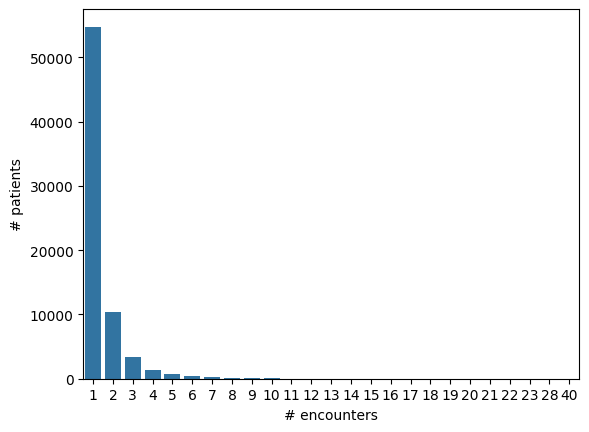

In [ ]:
df_patvisits = df.groupby('patient_nbr')['encounter_id'].count().reset_index(name = '#encounters') \
.groupby('#encounters')['patient_nbr'].count().reset_index(name = '#patients') \
.sort_values(by = '#patients', ascending = False).set_index('#encounters')
sns.barplot(x = df_patvisits.index, y = df_patvisits['#patients'])
plt.xlabel('# encounters')
plt.ylabel('# patients')
plt.show()


## REVIEW THIS STEP : Take the first encounter for each patient

In [ ]:
df = df.drop_duplicates(subset = ['patient_nbr'], keep = 'first')

# Analysis of columns and clean up

## Few helper methods

In [ ]:
def plotValueCounts(df, columnname):
  sns.countplot(x=columnname, data=df, order=df[columnname].value_counts().index)
  plt.xticks(rotation=90)
  plt.show()

In [ ]:
def plotPieChart(df, columnname):
  plt.pie(df[columnname].value_counts(), labels=df[columnname].value_counts().index, autopct='%1.1f%%')
  plt.show()

In [ ]:
def describeColumn(df, columnName):
    print(f'Column name: {columnName}')
    print(f'Data type: {df[columnName].dtype}')
    print()
    naSum = df[columnName].isna().sum()
    print(f'Count of NAs: {naSum}, %NAs = {naSum/len(df[columnName])*100}')
    print()
    uniqueValues = df[columnName].unique()
    print(f'Number of unique values: {len(uniqueValues)}')
    print()
    print('Unique values: ')
    print(f'{uniqueValues}')
    print()
    print('ValueCounts: ')
    print(df[columnName].value_counts())
    print()
    print('ValueCounts: Normalized')
    print(df[columnName].value_counts(normalize = True))
    print()
    if(df[columnName].dtype == 'number'):
      print('Column stats: ')
      print(df[columnName].describe())
    print()
    print('Column info: ')
    df[columnName].info()
    print()
    plotValueCounts(df, columnName)
    print()
    plotPieChart(df, columnName)


## 1. Column 'race'

Column name: race
Data type: object

Count of NAs: 1948, %NAs = 2.7237898151514304

Number of unique values: 6

Unique values: 
['Caucasian' 'AfricanAmerican' nan 'Other' 'Asian' 'Hispanic']

ValueCounts: 
race
Caucasian          53491
AfricanAmerican    12887
Hispanic            1517
Other               1178
Asian                497
Name: count, dtype: int64

ValueCounts: Normalized
race
Caucasian          0.768880
AfricanAmerican    0.185238
Hispanic           0.021805
Other              0.016933
Asian              0.007144
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71518 entries, 0 to 101765
Series name: race
Non-Null Count  Dtype 
--------------  ----- 
69570 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB



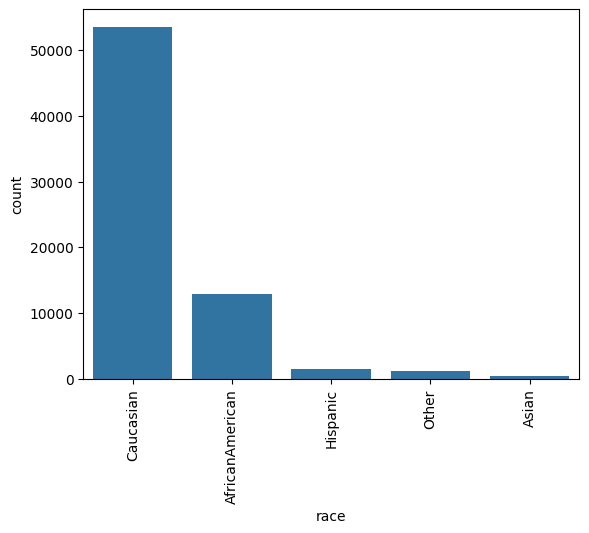

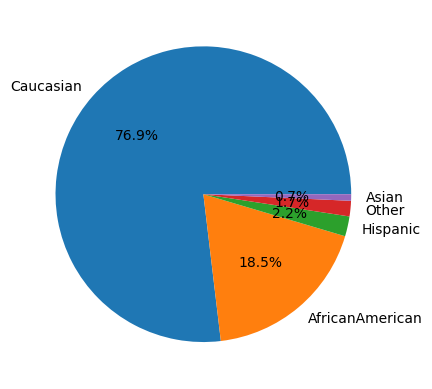

In [ ]:
describeColumn(df, 'race')

There is a good percentage of rows with 'nan' values, we will keep these rows with value 'Unknown'
Lets also change this column to category type.

In [ ]:
df['race'] = df['race'].fillna('Unknown')
df['race'] = df['race'].astype('category')

Caucasian race dominates the data followed by African American

## 2. Column 'gender'

Column name: gender
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 3

Unique values: 
['Female' 'Male' 'Unknown/Invalid']

ValueCounts: 
gender
Female             38025
Male               33490
Unknown/Invalid        3
Name: count, dtype: int64

ValueCounts: Normalized
gender
Female             0.531684
Male               0.468274
Unknown/Invalid    0.000042
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71518 entries, 0 to 101765
Series name: gender
Non-Null Count  Dtype 
--------------  ----- 
71518 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB



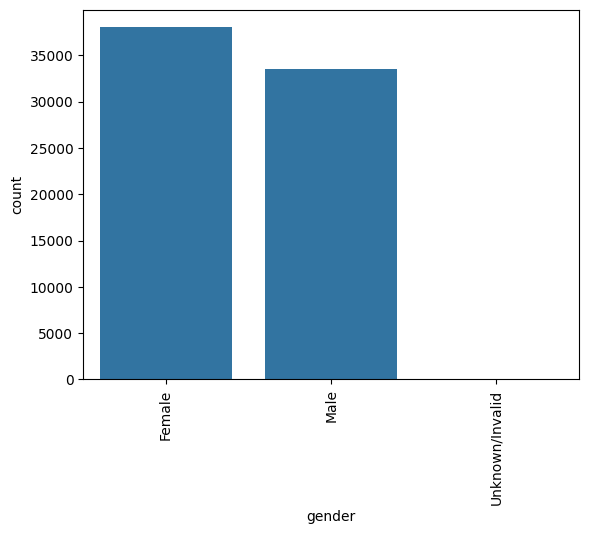

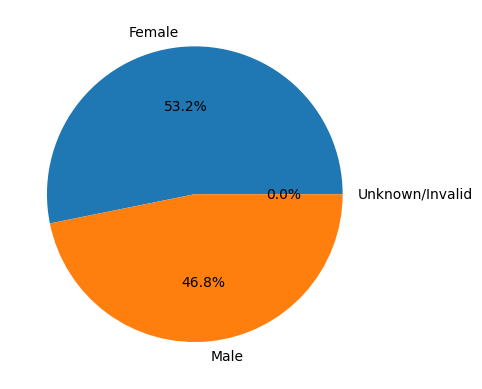

In [ ]:
describeColumn(df, 'gender')

Just three values are unknown, lets drop them.

In [ ]:
df.drop(df[df['gender'] == 'Unknown/Invalid'].index, inplace = True)

Lets convert column to category

In [ ]:
df['gender'] = df['gender'].astype('category')

## 3. Column 'readmitted'

Column name: readmitted
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 3

Unique values: 
['NO' '>30' '<30']

ValueCounts: 
readmitted
NO     42982
>30    22240
<30     6293
Name: count, dtype: int64

ValueCounts: Normalized
readmitted
NO     0.601021
>30    0.310984
<30    0.087996
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: readmitted
Non-Null Count  Dtype 
--------------  ----- 
71515 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB



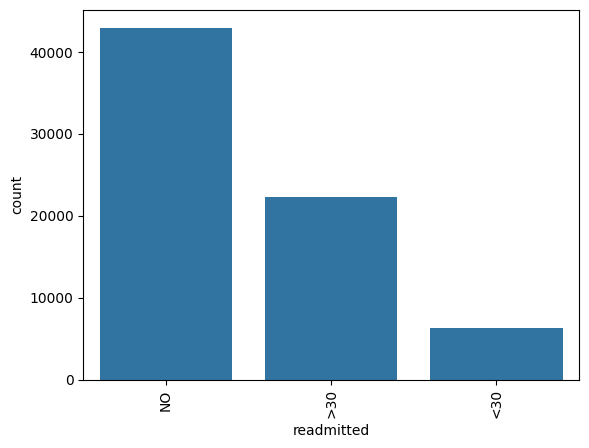

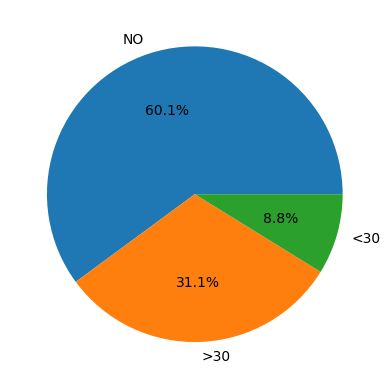

In [ ]:
describeColumn(df, 'readmitted')

### For first analysis lets consider readmission <30 days and >30 days as just readmission : YES

In [ ]:
df['readmitted'] = df['readmitted'].str.replace('>30', 'YES')
df['readmitted'] = df['readmitted'].str.replace('<30', 'YES')

### Lets convert the column to categorical

In [ ]:
df['readmitted'] = df['readmitted'].astype('category')

Column name: readmitted
Data type: category

Count of NAs: 0, %NAs = 0.0

Number of unique values: 2

Unique values: 
['NO', 'YES']
Categories (2, object): ['NO', 'YES']

ValueCounts: 
readmitted
NO     42982
YES    28533
Name: count, dtype: int64

ValueCounts: Normalized
readmitted
NO     0.601021
YES    0.398979
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: readmitted
Non-Null Count  Dtype   
--------------  -----   
71515 non-null  category
dtypes: category(1)
memory usage: 628.7 KB



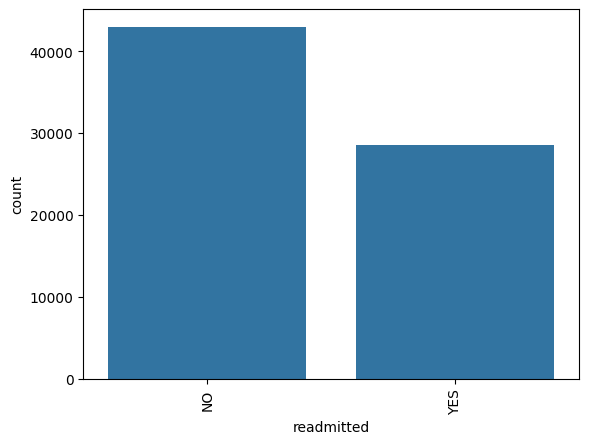

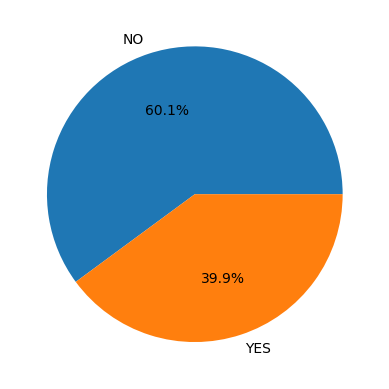

In [ ]:
describeColumn(df, 'readmitted')

## 4. Column 'weight'

Column name: weight
Data type: object

Count of NAs: 68662, %NAs = 96.0106271411592

Number of unique values: 10

Unique values: 
[nan '[75-100)' '[50-75)' '[0-25)' '[100-125)' '[25-50)' '[125-150)'
 '[175-200)' '[150-175)' '>200']

ValueCounts: 
weight
[75-100)     1195
[50-75)       781
[100-125)     566
[125-150)     131
[25-50)        89
[0-25)         46
[150-175)      33
[175-200)       9
>200            3
Name: count, dtype: int64

ValueCounts: Normalized
weight
[75-100)     0.418857
[50-75)      0.273747
[100-125)    0.198388
[125-150)    0.045917
[25-50)      0.031195
[0-25)       0.016123
[150-175)    0.011567
[175-200)    0.003155
>200         0.001052
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: weight
Non-Null Count  Dtype 
--------------  ----- 
2853 non-null   object
dtypes: object(1)
memory usage: 1.1+ MB



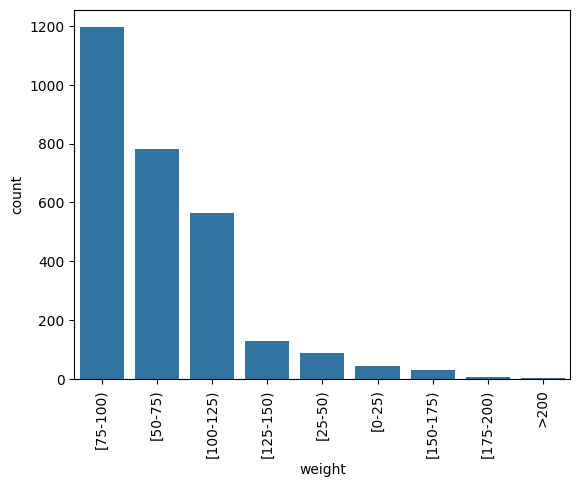

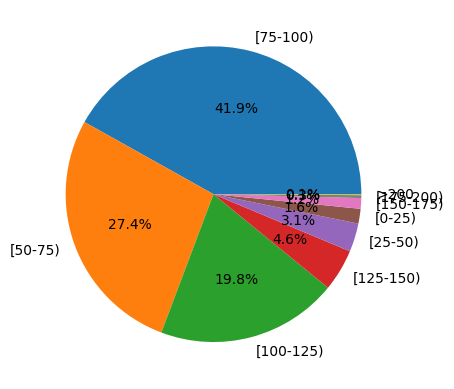

In [ ]:
describeColumn(df, 'weight')

There is a high percentage of rows without weight column, lets drop the column

In [ ]:
df = df.drop('weight', axis = 1)

## 5. Column 'payer_code'

Column name: payer_code
Data type: object

Count of NAs: 31042, %NAs = 43.40627840313221

Number of unique values: 18

Unique values: 
[nan 'MC' 'MD' 'HM' 'UN' 'BC' 'SP' 'CP' 'SI' 'DM' 'CM' 'CH' 'PO' 'WC' 'OT'
 'OG' 'MP' 'FR']

ValueCounts: 
payer_code
MC    20414
HM     4022
BC     3432
SP     3347
MD     2197
CP     1984
UN     1879
CM     1334
OG      658
PO      463
DM      374
CH      117
WC      117
OT       65
SI       37
MP       32
FR        1
Name: count, dtype: int64

ValueCounts: Normalized
payer_code
MC    0.504386
HM    0.099375
BC    0.084797
SP    0.082697
MD    0.054283
CP    0.049020
UN    0.046426
CM    0.032960
OG    0.016258
PO    0.011440
DM    0.009241
CH    0.002891
WC    0.002891
OT    0.001606
SI    0.000914
MP    0.000791
FR    0.000025
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: payer_code
Non-Null Count  Dtype 
--------------  ----- 
40473 non-null  object
dtypes: object

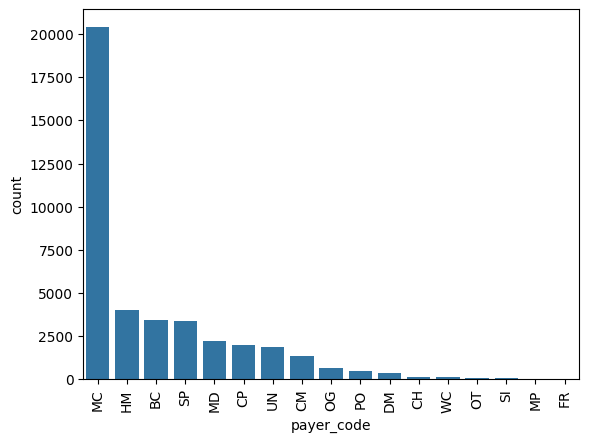

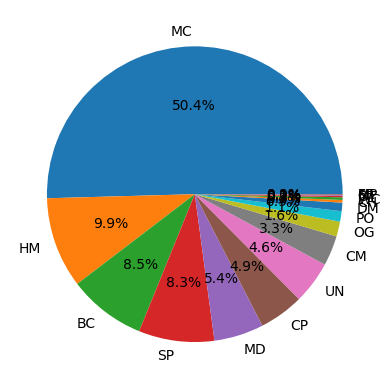

In [ ]:
describeColumn(df, 'payer_code')

The column 'payer_code' which may not influence readmission. Further more > 50% of the values are not available, we decide to drop this column.

In [ ]:
df = df.drop('payer_code', axis = 1)

## 6. Column 'medical_specialty'

Column name: medical_specialty
Data type: object

Count of NAs: 34475, %NAs = 48.20666992938544

Number of unique values: 71

Unique values: 
['Pediatrics-Endocrinology' nan 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Anesthesiology-Pediatric' 'Radiology'
 'Pediatrics-Hematology-Oncology' 'Psychology' 'Neurology' 'Podiatry'
 'Gynecology' 'Oncology' 'Pediatrics-Neurology' 'Surgery-Thoracic'
 'Surgery-PlasticwithinHeadandNeck' 'Surgery-Plastic' 'Ophthalmology'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabi

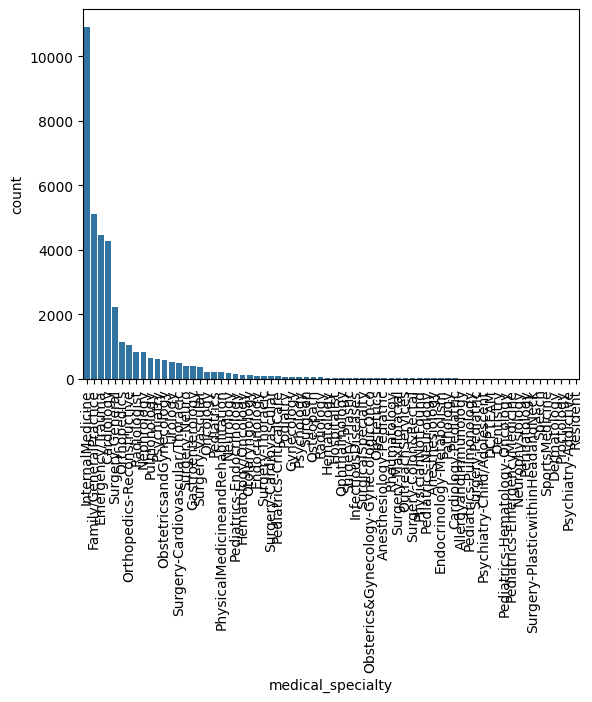

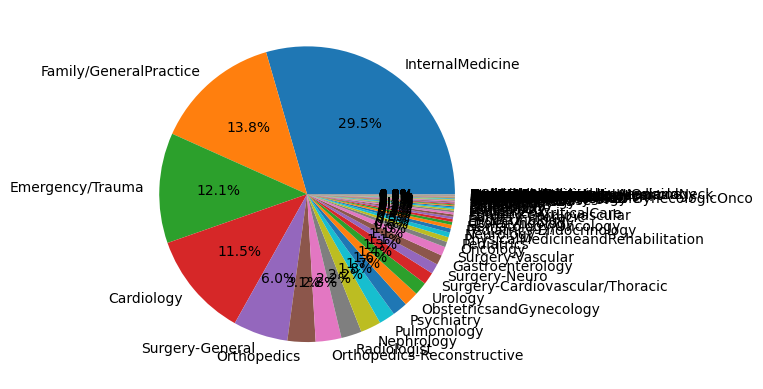

In [ ]:
describeColumn(df, 'medical_specialty')

Even though the column has high percentage of missing values, we believe it could contribute to readmission. We retain the column by replacing missing values with 'Unknown'

In [ ]:
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')

Column name: medical_specialty
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 71

Unique values: 
['Pediatrics-Endocrinology' 'Unknown' 'InternalMedicine'
 'Family/GeneralPractice' 'Cardiology' 'Surgery-General' 'Orthopedics'
 'Gastroenterology' 'Surgery-Cardiovascular/Thoracic' 'Nephrology'
 'Orthopedics-Reconstructive' 'Psychiatry' 'Emergency/Trauma'
 'Pulmonology' 'Surgery-Neuro' 'Obsterics&Gynecology-GynecologicOnco'
 'ObstetricsandGynecology' 'Pediatrics' 'Hematology/Oncology'
 'Otolaryngology' 'Surgery-Colon&Rectal' 'Pediatrics-CriticalCare'
 'Endocrinology' 'Urology' 'Psychiatry-Child/Adolescent'
 'Pediatrics-Pulmonology' 'Anesthesiology-Pediatric' 'Radiology'
 'Pediatrics-Hematology-Oncology' 'Psychology' 'Neurology' 'Podiatry'
 'Gynecology' 'Oncology' 'Pediatrics-Neurology' 'Surgery-Thoracic'
 'Surgery-PlasticwithinHeadandNeck' 'Surgery-Plastic' 'Ophthalmology'
 'Surgery-Pediatric' 'Pediatrics-EmergencyMedicine'
 'PhysicalMedicineandRehabilitation' 'I

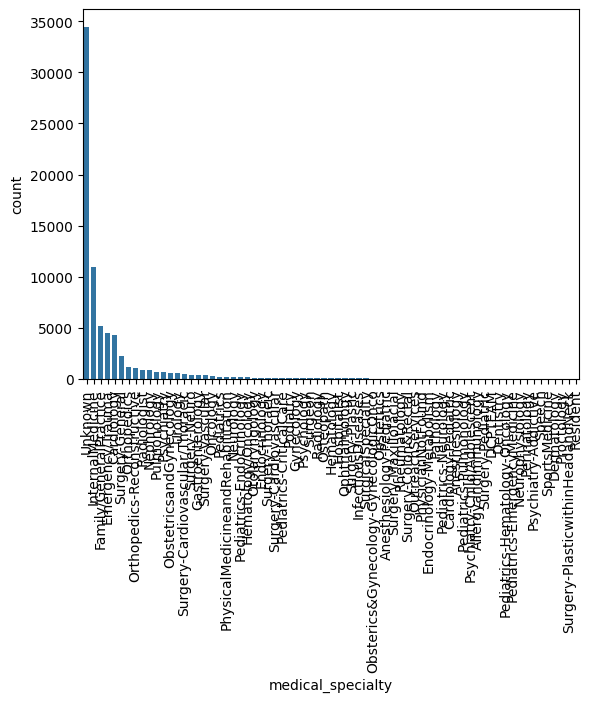

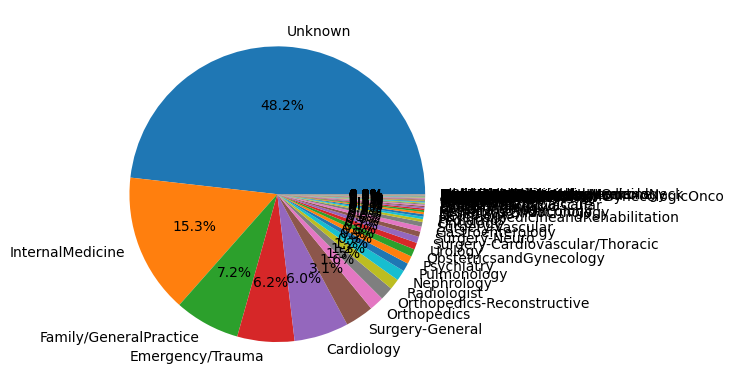

In [ ]:
describeColumn(df, 'medical_specialty')

Finally we convert the column to category.

In [ ]:
df['medical_specialty'] = df['medical_specialty'].astype('category')

## 7. Medicine columns

### e.g 'metformin'

Column name: metformin
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 4

Unique values: 
['No' 'Steady' 'Up' 'Down']

ValueCounts: 
metformin
No        56525
Steady    13717
Up          838
Down        435
Name: count, dtype: int64

ValueCounts: Normalized
metformin
No        0.790394
Steady    0.191806
Up        0.011718
Down      0.006083
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: metformin
Non-Null Count  Dtype 
--------------  ----- 
71515 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB



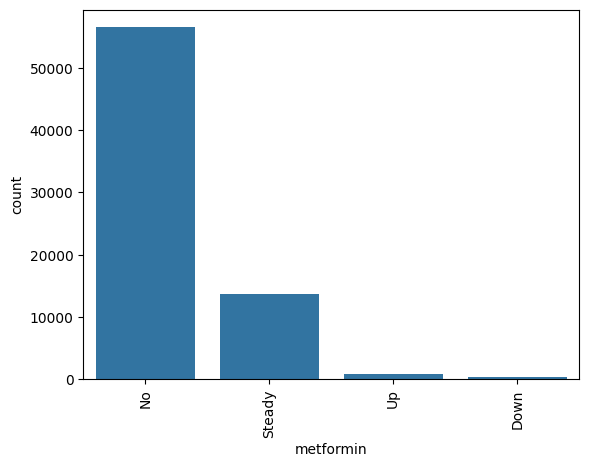

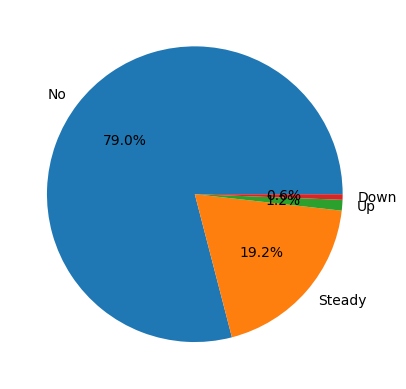

In [ ]:
describeColumn(df, 'metformin')

### All medicine columns

In [ ]:
medicine_columns = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone']

In [ ]:
df[medicine_columns].isna().sum()

metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose                    0
miglitol                    0
troglitazone                0
tolazamide                  0
examide                     0
citoglipton                 0
insulin                     0
glyburide-metformin         0
glipizide-metformin         0
glimepiride-pioglitazone    0
metformin-rosiglitazone     0
metformin-pioglitazone      0
dtype: int64

None of the medicine columns have 'na' values.
Features for medicine, indicate whether
the drug was prescribed or there was a change in the dosage. Values:

“up” if the dosage was increased during the encounter,  
“down” if the dosage was decreased,  
“steady” if the dosage did not change, and   
“no” if the drug was not prescribed  

We make these columns as type 'category'

In [ ]:
df[medicine_columns] = df[medicine_columns].astype('category')

Column name: tolbutamide
Data type: category

Count of NAs: 0, %NAs = 0.0

Number of unique values: 2

Unique values: 
['No', 'Steady']
Categories (2, object): ['No', 'Steady']

ValueCounts: 
tolbutamide
No        71496
Steady       19
Name: count, dtype: int64

ValueCounts: Normalized
tolbutamide
No        0.999734
Steady    0.000266
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: tolbutamide
Non-Null Count  Dtype   
--------------  -----   
71515 non-null  category
dtypes: category(1)
memory usage: 628.7 KB



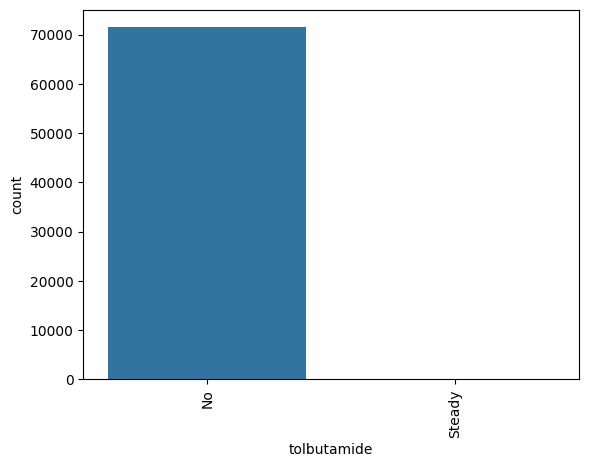

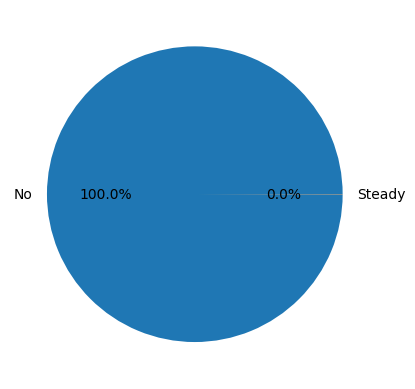

In [ ]:
describeColumn(df, 'tolbutamide')

Many of these columns seem sparse. Lets analyze the sparsity

In [ ]:
def analyze_sparsity(df):
    sparse_cols = (df == 'No').sum() / df.shape[0]
    sparse_cols.sort_values(ascending=False, inplace=True)

    sparse_cols_filtered = sparse_cols[sparse_cols >= 0.99].index
    nonsparse_cols_filtered = sparse_cols[sparse_cols <= 0.99].index

    max_len = max(len(col) for col in sparse_cols.index)

    print("Sparse columns (>=99% with value 'No'): \n")
    for col in sparse_cols_filtered:
        print(f"{col:<{max_len}} - sparcity: {sparse_cols[col]:.4f}")
    print("\nNon-sparse columns (<99% with value 'No'): \n")
    for col in nonsparse_cols_filtered:
        print(f"{col:<{max_len}} - sparcity: {sparse_cols[col]:.4f}")

    return sparse_cols_filtered, nonsparse_cols_filtered

In [ ]:
sparse_columns, nonsparse_columns = analyze_sparsity(df[medicine_columns])

Sparse columns (>=99% with value 'No'): 

glimepiride-pioglitazone - sparcity: 1.0000
citoglipton              - sparcity: 1.0000
examide                  - sparcity: 1.0000
metformin-pioglitazone   - sparcity: 1.0000
acetohexamide            - sparcity: 1.0000
metformin-rosiglitazone  - sparcity: 1.0000
troglitazone             - sparcity: 1.0000
glipizide-metformin      - sparcity: 0.9999
tolbutamide              - sparcity: 0.9997
miglitol                 - sparcity: 0.9997
tolazamide               - sparcity: 0.9996
chlorpropamide           - sparcity: 0.9990
acarbose                 - sparcity: 0.9972
nateglinide              - sparcity: 0.9930
glyburide-metformin      - sparcity: 0.9930

Non-sparse columns (<99% with value 'No'): 

repaglinide              - sparcity: 0.9871
glimepiride              - sparcity: 0.9476
rosiglitazone            - sparcity: 0.9343
pioglitazone             - sparcity: 0.9258
glyburide                - sparcity: 0.8902
glipizide                - sparc

We have choice, for now we drop all sparse columns

In [ ]:
df = df.drop(sparse_columns, axis = 1)

## lets look at remaining columns

In [ ]:
len(df.columns)

33

In [ ]:
df.select_dtypes(include=['object']).columns

Index(['age', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum', 'A1Cresult',
       'change', 'diabetesMed'],
      dtype='object')

## 8. Column 'age'

Column name: age
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 10

Unique values: 
['[0-10)' '[10-20)' '[20-30)' '[30-40)' '[40-50)' '[50-60)' '[60-70)'
 '[70-80)' '[80-90)' '[90-100)']

ValueCounts: 
age
[70-80)     18208
[60-70)     15959
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: count, dtype: int64

ValueCounts: Normalized
age
[70-80)     0.254604
[60-70)     0.223156
[50-60)     0.174313
[80-90)     0.162050
[40-50)     0.096176
[30-40)     0.037740
[90-100)    0.026568
[20-30)     0.015759
[10-20)     0.007481
[0-10)      0.002153
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: age
Non-Null Count  Dtype 
--------------  ----- 
71515 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB



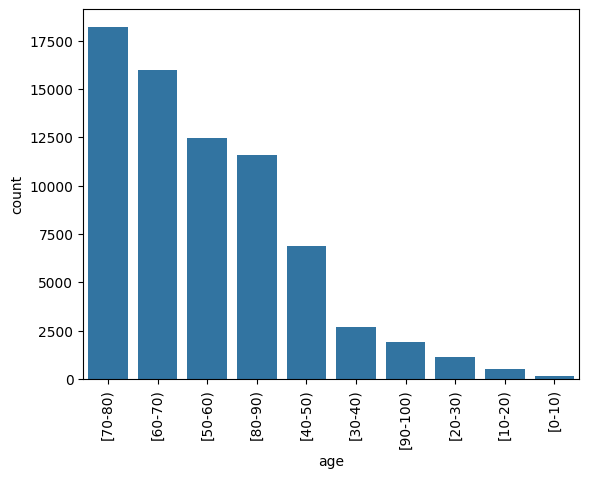

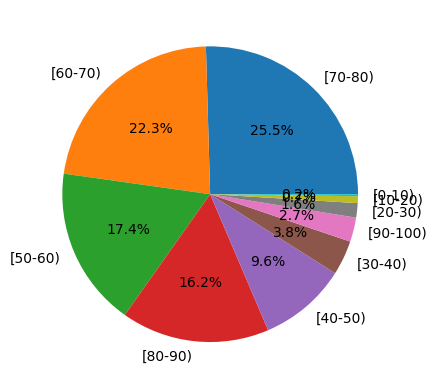

In [ ]:
describeColumn(df, 'age')

Lets bin the column. There are very few values < 30, lets bin them to a single bin.

In [ ]:
# Define the bin edges and labels
bin_edges = [0, 30, 40, 50, 60, 70, 80, 90, 100]
bin_labels = ['0-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
df['age-binned'] = pd.cut(df['age'].str.extract('(\d+)')[0].astype(int), bins=bin_edges, labels=bin_labels, right=False)

Column name: age-binned
Data type: category

Count of NAs: 0, %NAs = 0.0

Number of unique values: 8

Unique values: 
['0-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']
Categories (8, object): ['0-30' < '30-40' < '40-50' < '50-60' < '60-70' < '70-80' < '80-90' < '90-100']

ValueCounts: 
age-binned
70-80     18208
60-70     15959
50-60     12466
80-90     11589
40-50      6878
30-40      2699
90-100     1900
0-30       1816
Name: count, dtype: int64

ValueCounts: Normalized
age-binned
70-80     0.254604
60-70     0.223156
50-60     0.174313
80-90     0.162050
40-50     0.096176
30-40     0.037740
90-100    0.026568
0-30      0.025393
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: age-binned
Non-Null Count  Dtype   
--------------  -----   
71515 non-null  category
dtypes: category(1)
memory usage: 628.9 KB



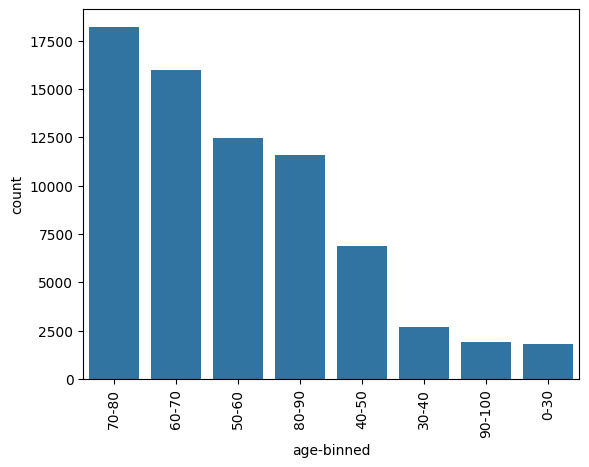

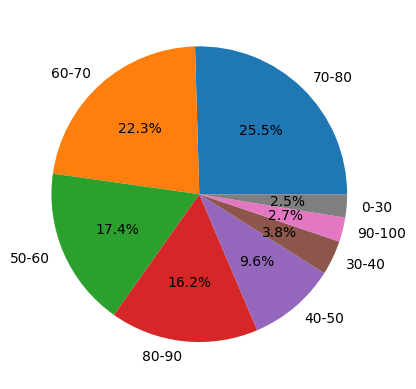

In [ ]:
describeColumn(df, 'age-binned')

Now that we have 'age-binned', lets drop 'age' column

In [ ]:
df = df.drop('age', axis = 1)

## 9.the 'diag' columns

Column name: diag_1
Data type: object

Count of NAs: 11, %NAs = 0.015381388519890933

Number of unique values: 697

Unique values: 
['250.83' '276' '648' '8' '197' '414' '428' '398' '434' '250.7' '157'
 '518' '999' '410' '682' '402' '737' '572' 'V57' '189' '786' '427' '996'
 '277' '584' '462' '473' '411' '174' '486' '998' '511' '432' '626' '295'
 '196' '250.6' '618' '182' '845' '423' '808' '250.4' '722' '403' '250.11'
 '784' '707' '440' '151' '715' '997' '564' '812' '38' '590' '556' '578'
 '250.32' '433' 'V58' '569' '185' '536' '255' '250.13' '599' '558' '574'
 '491' '560' '244' '250.03' '577' '730' '188' '824' '250.8' '332' '562'
 '291' '296' '510' '401' '263' '438' '70' '250.02' '493' '642' '625' '571'
 '738' '593' '250.42' '807' '456' '446' '575' '250.41' '820' '515' '780'
 '250.22' '995' '235' '250.82' '721' '787' '162' '724' '282' '514' 'V55'
 '281' '250.33' '466' '435' '250.12' 'V53' '789' '566' '822' '191' '557'
 '733' '198' '455' '711' '482' '202' '280' '553' '225' '154' '441'


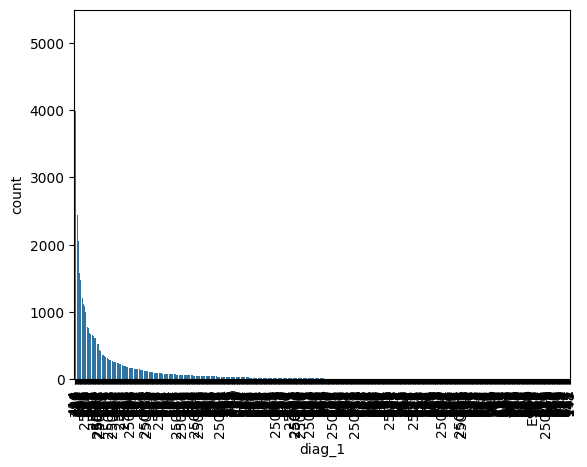

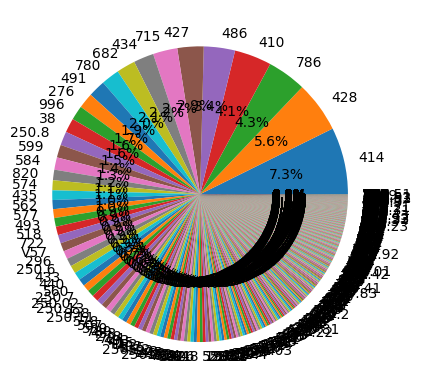

In [ ]:
describeColumn(df, 'diag_1')

Column name: diag_2
Data type: object

Count of NAs: 294, %NAs = 0.4111025658952667

Number of unique values: 726

Unique values: 
[nan '250.01' '250' '250.43' '157' '411' '492' '427' '198' '403' '288'
 '998' '507' '174' '425' '456' '401' '715' '496' '428' '585' '250.02'
 '410' '999' '996' '135' '244' '41' '571' '276' '997' '599' '424' '491'
 '553' '707' '286' '440' '493' '242' '70' 'V45' '250.03' '357' '511' '196'
 '396' '414' '250.52' '577' '535' '413' '285' '53' '780' '518' '150' '566'
 '250.6' '867' '486' 'V15' '8' '788' '340' '574' '581' '228' '530'
 '250.82' '786' '294' '567' '785' '512' '305' '729' '250.51' '280' '648'
 '560' '618' '444' '38' 'V10' '578' '277' '781' '250.42' '278' '426' '584'
 '462' '402' '153' '272' '733' '34' '881' '203' '250.41' '293' '245'
 '250.12' '558' '787' '342' '573' '626' '303' '250.53' '458' '710' '415'
 'V42' '284' '569' '759' '112' '292' '435' '682' '290' '250.13' '250.93'
 '642' '536' '398' '319' '711' 'E878' '446' '255' 'V44' '250.7' '300'
 '562'

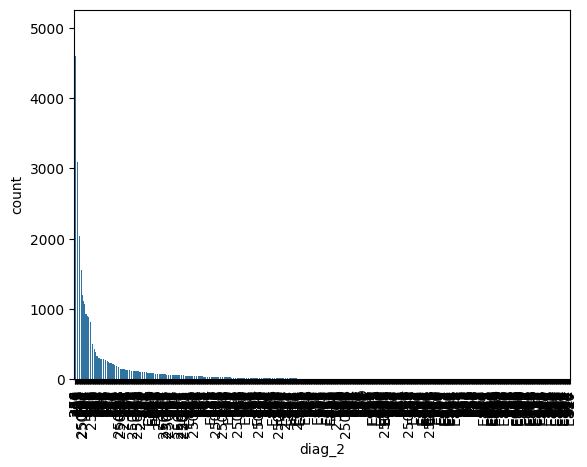

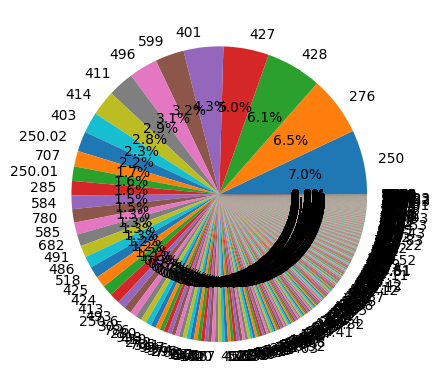

In [ ]:
describeColumn(df, 'diag_2')

diag_ columns contain a mix of numeric and non numeric values. Lets take a look at non-numeric ones

There are a few NA values in the columns. Lets replace them with 'Unknown'

In [ ]:
df['diag_1'].fillna('Unknown', inplace=True)
df['diag_2'].fillna('Unknown', inplace=True)
df['diag_3'].fillna('Unknown', inplace=True)

<ipython-input-511-c1483c4efac3>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['diag_1'].fillna('Unknown', inplace=True)
<ipython-input-511-c1483c4efac3>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [ ]:
df[df['diag_1'].str.isnumeric() == False]['diag_1'].unique()

array(['250.83', '250.7', 'V57', '250.6', '250.4', '250.11', '250.32',
       'V58', '250.13', '250.03', '250.8', '250.02', '250.42', '250.41',
       '250.22', '250.82', 'V55', '250.33', '250.12', 'V53', '250.81',
       'Unknown', '250.93', '250.01', '250.31', '250.43', '250.1',
       '250.2', '250.3', '250.23', '250.5', '250.92', 'V45', '250.21',
       'V26', '250.9', 'V71', 'V56', 'V67', 'V60', 'V54', '250.52',
       '250.51', 'V43', '250.91', '250.53', 'V63', 'V25', 'V70', 'E909',
       'V66', 'V51'], dtype=object)

In [ ]:
df[df['diag_1'].str.contains('[a-zA-Z]') == True]['diag_1'].unique()

array(['V57', 'V58', 'V55', 'V53', 'Unknown', 'V45', 'V26', 'V71', 'V56',
       'V67', 'V60', 'V54', 'V43', 'V63', 'V25', 'V70', 'E909', 'V66',
       'V51'], dtype=object)

Apparently these are all valid codes for diseases. We just have to treat the values as they are. And model them as categorical values.

In [ ]:
df['diag_1'] = df['diag_1'].astype('category')
df['diag_2'] = df['diag_2'].astype('category')
df['diag_3'] = df['diag_3'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71515 entries, 0 to 101765
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              71515 non-null  int64   
 1   patient_nbr               71515 non-null  int64   
 2   race                      71515 non-null  category
 3   gender                    71515 non-null  category
 4   admission_type_id         71515 non-null  int64   
 5   discharge_disposition_id  71515 non-null  int64   
 6   admission_source_id       71515 non-null  int64   
 7   time_in_hospital          71515 non-null  int64   
 8   medical_specialty         71515 non-null  category
 9   num_lab_procedures        71515 non-null  int64   
 10  num_procedures            71515 non-null  int64   
 11  num_medications           71515 non-null  int64   
 12  number_outpatient         71515 non-null  int64   
 13  number_emergency          71515 non-null  int64   

## max_glu_serum

Column name: max_glu_serum
Data type: object

Count of NAs: 68059, %NAs = 95.16744738865972

Number of unique values: 4

Unique values: 
[nan '>300' 'Norm' '>200']

ValueCounts: 
max_glu_serum
Norm    1731
>200     969
>300     756
Name: count, dtype: int64

ValueCounts: Normalized
max_glu_serum
Norm    0.500868
>200    0.280382
>300    0.218750
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: max_glu_serum
Non-Null Count  Dtype 
--------------  ----- 
3456 non-null   object
dtypes: object(1)
memory usage: 1.1+ MB



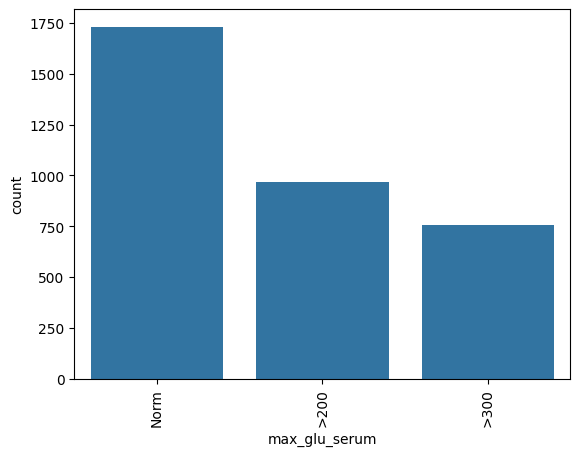

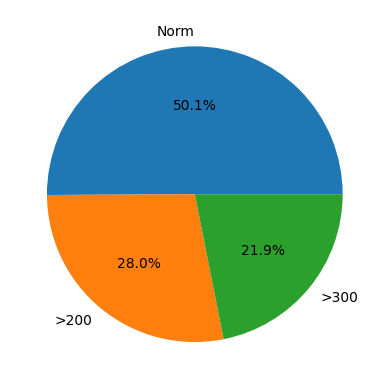

In [ ]:
describeColumn(df, 'max_glu_serum')

There are lot of rows with column values as NA (None), which represents the value was not measured.

Glucose serum test result  
Nominal  
Indicates the range of the result or if the test was not taken.  
Values: “>200,” “>300,”, “normal,” and “none” if not measured.  

We split the column to two columns:  
max_glu_serum = Ordinal encoding 0,1,2,3  
max_glu_serum_measured = Yes/No  


In [ ]:
def splitToCategoricalAnOrdinalColumns(df, column):
  df[f'{column}_measured'] = df[column].apply(lambda x: 'No' if pd.isna(x) else 'Yes').astype('category')
  ordinal_mapping = {np.NaN : 0, 'Norm': 1, '>200': 2, '>300': 3 }
  df[column] = df[column].apply(lambda x: 'No' if pd.isna(x) else 'Yes').astype('category')

In [ ]:
df['max_glu_serum'].unique()

array([nan, '>300', 'Norm', '>200'], dtype=object)

In [ ]:
# Create the 'measured' column (Yes/No)
df['max_glu_serum_measured'] = df['max_glu_serum'].apply(lambda x: 'No' if pd.isna(x) else 'Yes')
df['max_glu_serum_measured'] = df['max_glu_serum_measured'].astype('category')
ordinal_mapping = {np.NaN : 0, 'Norm': 1, '>200': 2, '>300': 3 }
df['max_glu_serum'] = df['max_glu_serum'].map(ordinal_mapping)

## We do the same stuff for A1Cresult.

In [ ]:
df['A1Cresult'].unique()

array([nan, '>7', '>8', 'Norm'], dtype=object)

In [ ]:
df['A1Cresult_measured'] = df['A1Cresult'].apply(lambda x: 'No' if pd.isna(x) else 'Yes')
df['A1Cresult_measured'] = df['A1Cresult_measured'].astype('category')
ordinal_mapping = {np.NaN : 0, 'Norm': 1, '>7': 2, '>8': 3 }
df['A1Cresult'] = df['A1Cresult'].map(ordinal_mapping)

In [ ]:
df['A1Cresult'].value_counts()

A1Cresult
0    58529
3     6304
1     3791
2     2891
Name: count, dtype: int64

## Revaluate Medicine columns


In [ ]:
for col in nonsparse_columns:
  df[f'{col}_measured'] = df[col].apply(lambda x: 'No' if x == 'No' else 'Yes')
  df[f'{col}_measured'] = df[f'{col}_measured'].astype('category')
  ordinal_mapping = {'Down' : -1, 'No': 0, 'Steady': 1, 'Up': 2 }
  df[col] = df[col].map(ordinal_mapping).astype('float')
#

In [ ]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'change', 'diabetesMed', 'readmitted', 'age-binned',
       'max_glu_serum_measured', 'A1Cresult_measured', 'repaglinide_measured',
       'glimepiride_measured', 'rosiglitazone_measured',
       'pioglitazone_measured', 'glyburide_measured', 'glipizide_measured',
       'metformin_measured', 'insulin_measured'],
      dtype='object')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71515 entries, 0 to 101765
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              71515 non-null  int64   
 1   patient_nbr               71515 non-null  int64   
 2   race                      71515 non-null  category
 3   gender                    71515 non-null  category
 4   admission_type_id         71515 non-null  int64   
 5   discharge_disposition_id  71515 non-null  int64   
 6   admission_source_id       71515 non-null  int64   
 7   time_in_hospital          71515 non-null  int64   
 8   medical_specialty         71515 non-null  category
 9   num_lab_procedures        71515 non-null  int64   
 10  num_procedures            71515 non-null  int64   
 11  num_medications           71515 non-null  int64   
 12  number_outpatient         71515 non-null  int64   
 13  number_emergency          71515 non-null  int64   

## The column 'change'

Column name: change
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 2

Unique values: 
['No' 'Ch']

ValueCounts: 
change
No    39493
Ch    32022
Name: count, dtype: int64

ValueCounts: Normalized
change
No    0.552234
Ch    0.447766
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: change
Non-Null Count  Dtype 
--------------  ----- 
71515 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB



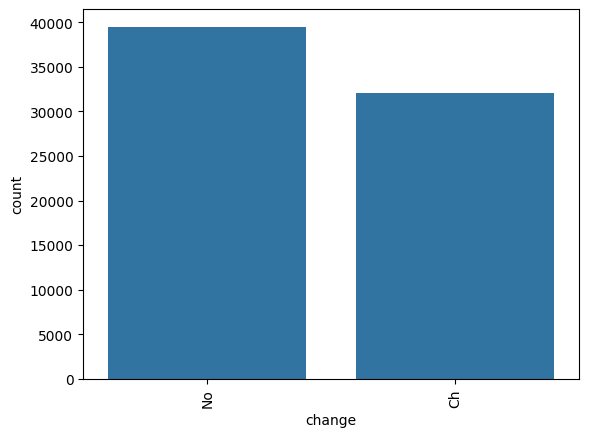

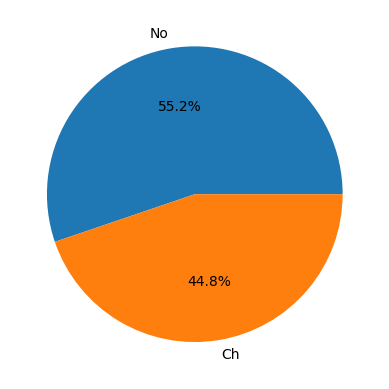

In [ ]:
describeColumn(df, 'change')

In [ ]:
df['change'] = df['change'].astype('category')

## Column 'diabetesMed'

Column name: diabetesMed
Data type: object

Count of NAs: 0, %NAs = 0.0

Number of unique values: 2

Unique values: 
['No' 'Yes']

ValueCounts: 
diabetesMed
Yes    54317
No     17198
Name: count, dtype: int64

ValueCounts: Normalized
diabetesMed
Yes    0.759519
No     0.240481
Name: proportion, dtype: float64


Column info: 
<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: diabetesMed
Non-Null Count  Dtype 
--------------  ----- 
71515 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB



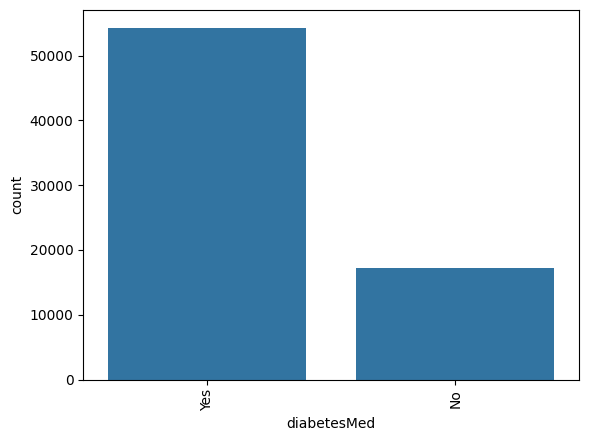

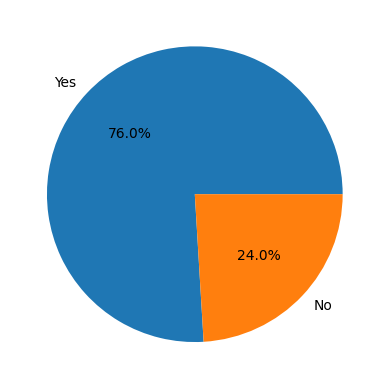

In [ ]:
describeColumn(df, 'diabetesMed')

In [ ]:
df['diabetesMed'] = df['diabetesMed'].astype('category')

# Univariate - Numerical Columns

## Helper methods

In [ ]:
def describeColumnNumerical(df, columnName):
    print(f'Column name: {columnName}')
    print(f'Data type: {df[columnName].dtype}')

    print()
    print('Value counts: ')
    print(df[columnName].value_counts())

    print()
    naSum = df[columnName].isna().sum()
    print(f'Count of NAs: {naSum}, %NAs = {naSum/len(df[columnName])*100}')

    print()
    print(df[columnName].info())

    print()
    print(df[columnName].describe())

    print()
    sns.barplot(x=df['readmitted'], y=df[columnName])
    plt.xticks(rotation=90)
    plt.show()

    print()
    sns.boxplot(x=df['readmitted'], y=df[columnName])
    plt.xticks(rotation=90)
    plt.show()

    print()
    sns.histplot( data = df, x= columnName, kde=True, hue='readmitted', multiple='stack')
    plt.show()


In [ ]:
numerical_columns = df.select_dtypes(include=['number']).columns
numerical_columns

Index(['encounter_id', 'patient_nbr', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'glimepiride', 'glipizide', 'glyburide', 'pioglitazone',
       'rosiglitazone', 'insulin'],
      dtype='object')

## 'time_in_hospital'

Column name: time_in_hospital
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: time_in_hospital
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean         4.289170
std          2.949188
min          1.000000
25%          2.000000
50%          3.000000
75%          6.000000
max         14.000000
Name: time_in_hospital, dtype: float64



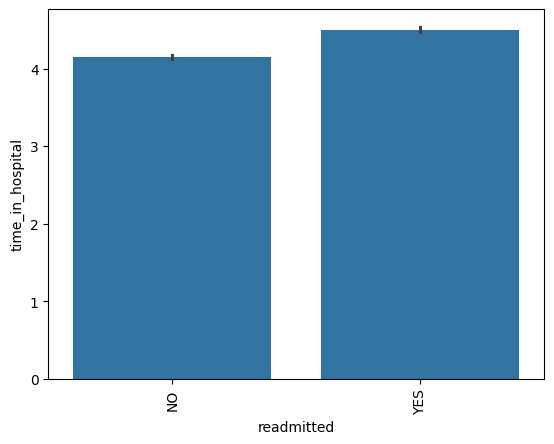

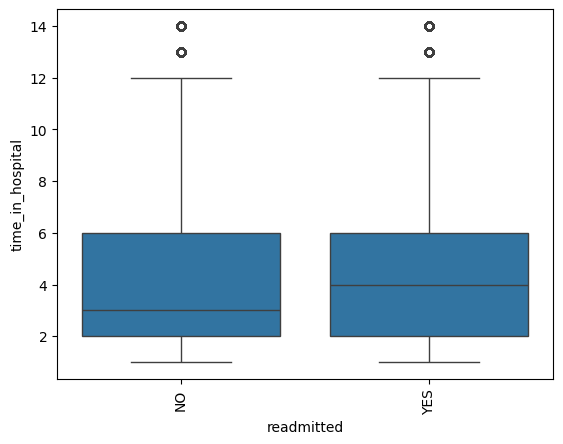

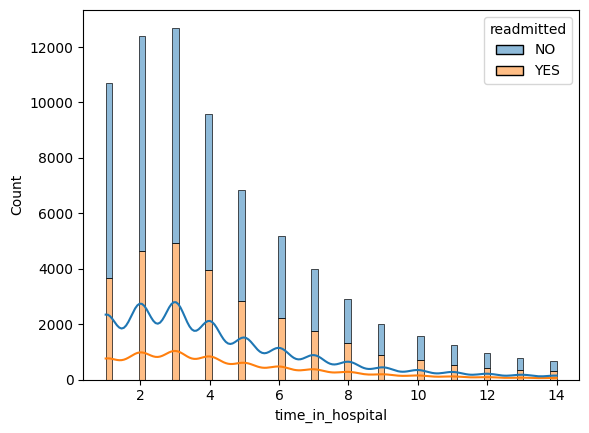

In [ ]:
describeColumnNumerical(df, 'time_in_hospital')

Column name: num_lab_procedures
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: num_lab_procedures
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean        43.075858
std         19.952151
min          1.000000
25%         31.000000
50%         44.000000
75%         57.000000
max        132.000000
Name: num_lab_procedures, dtype: float64



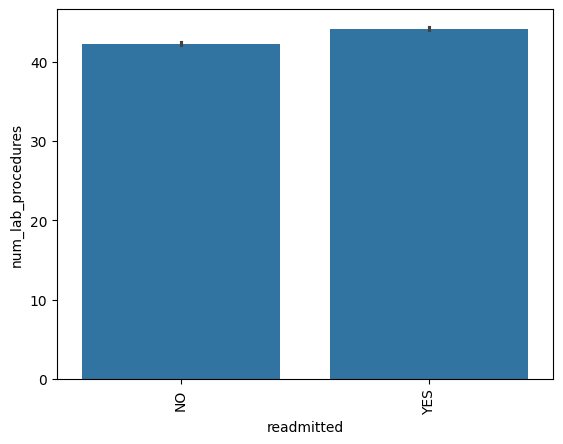

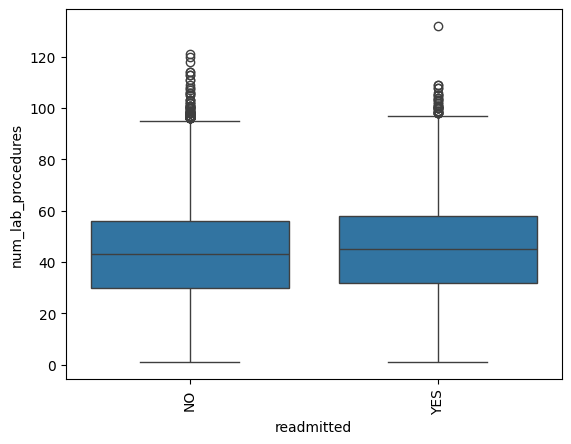

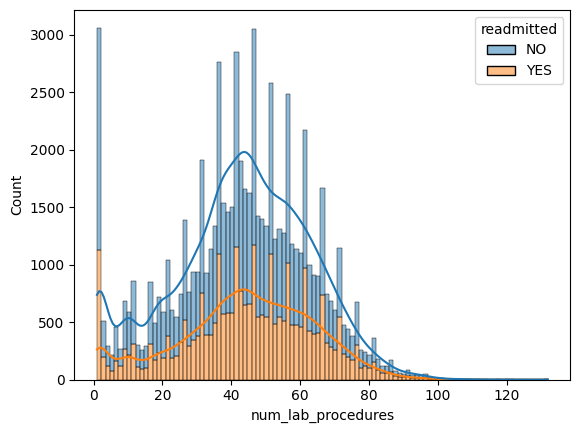

In [ ]:
describeColumnNumerical(df, 'num_lab_procedures')

Column name: num_procedures
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: num_procedures
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean         1.430525
std          1.759848
min          0.000000
25%          0.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: num_procedures, dtype: float64



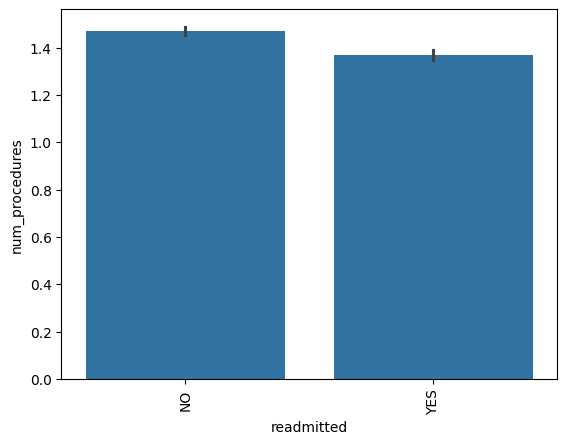

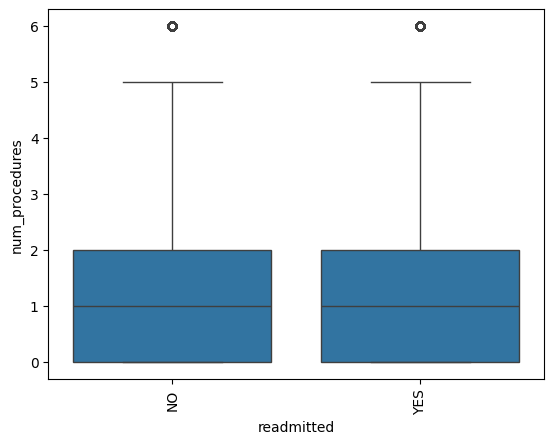

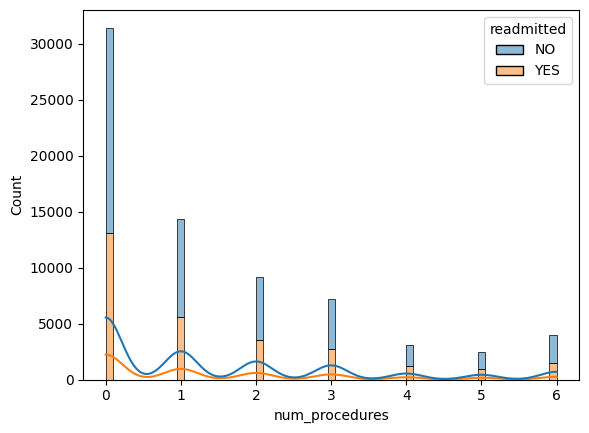

In [ ]:
describeColumnNumerical(df, 'num_procedures')

Column name: num_medications
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: num_medications
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean        15.704999
std          8.311201
min          1.000000
25%         10.000000
50%         14.000000
75%         20.000000
max         81.000000
Name: num_medications, dtype: float64



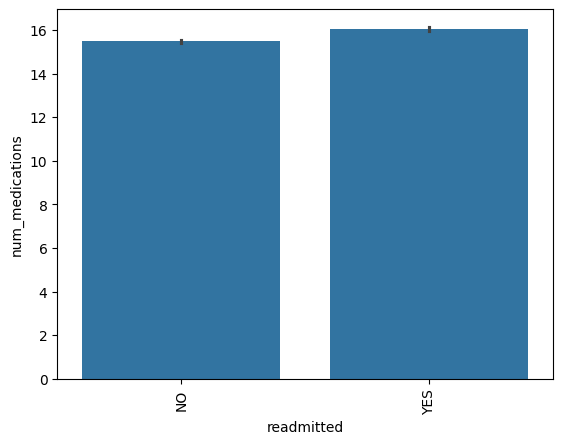

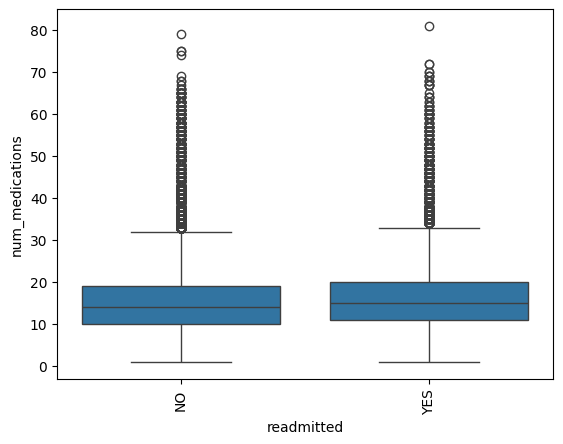

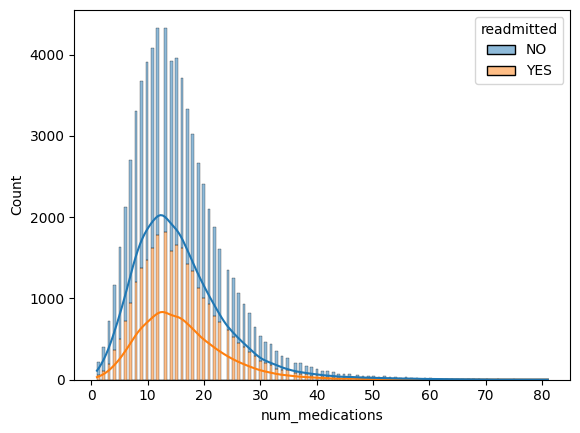

In [ ]:
describeColumnNumerical(df, 'num_medications')

Column name: number_outpatient
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: number_outpatient
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean         0.280081
std          1.068978
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.000000
Name: number_outpatient, dtype: float64



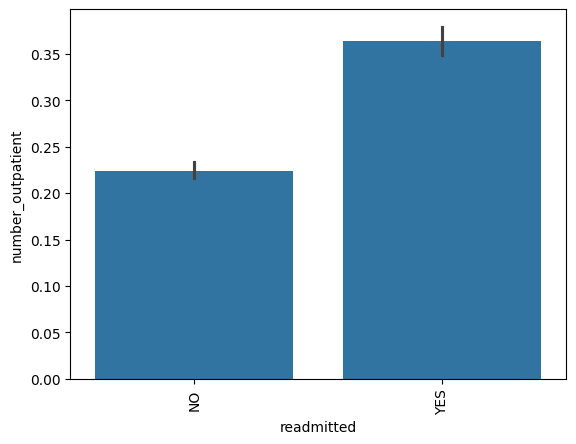

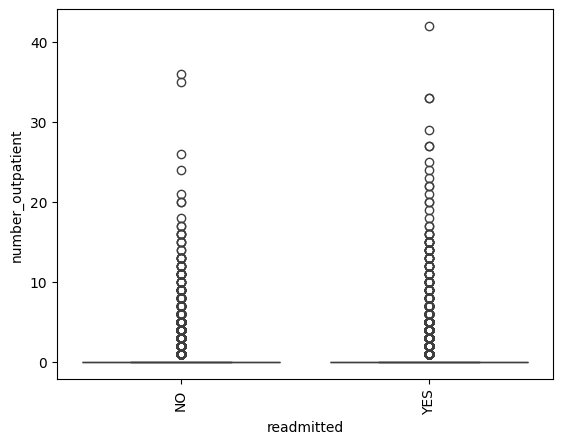

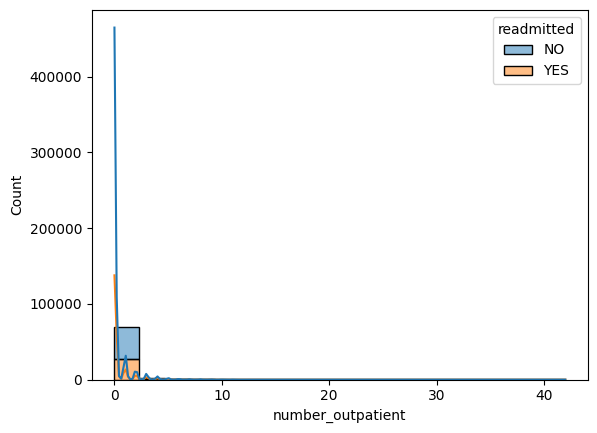

In [ ]:
describeColumnNumerical(df, 'number_outpatient')

Column name: number_emergency
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: number_emergency
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean         0.103545
std          0.509197
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         42.000000
Name: number_emergency, dtype: float64



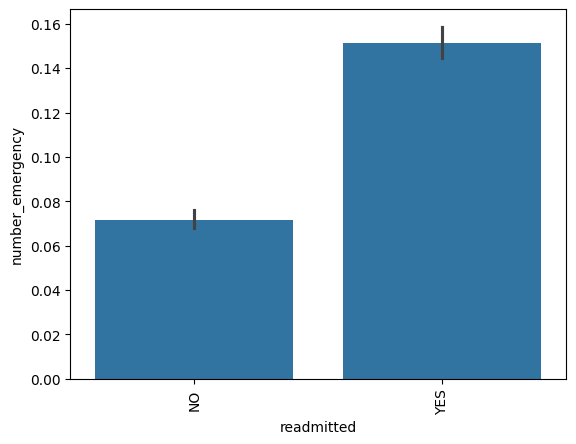

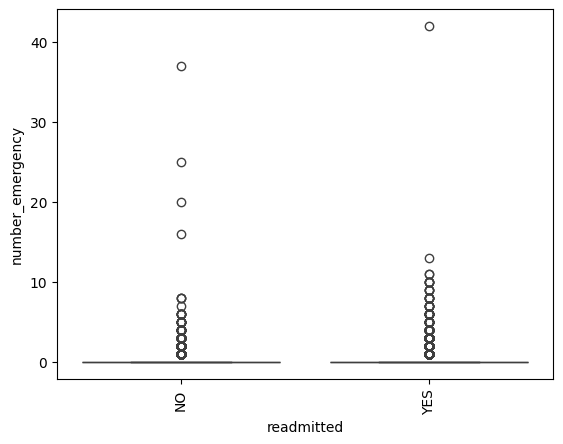

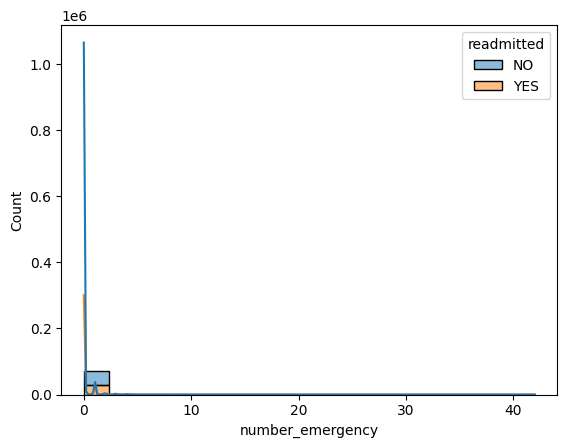

In [ ]:
describeColumnNumerical(df, 'number_emergency')

Column name: number_inpatient
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: number_inpatient
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean         0.177837
std          0.603801
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         12.000000
Name: number_inpatient, dtype: float64



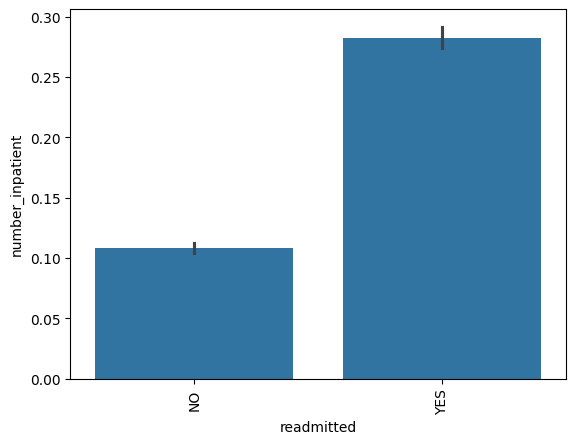

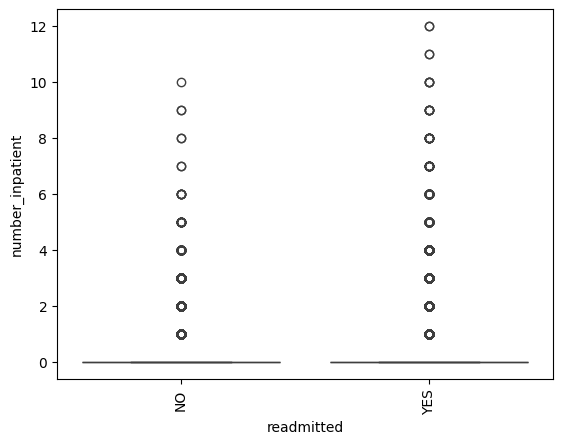

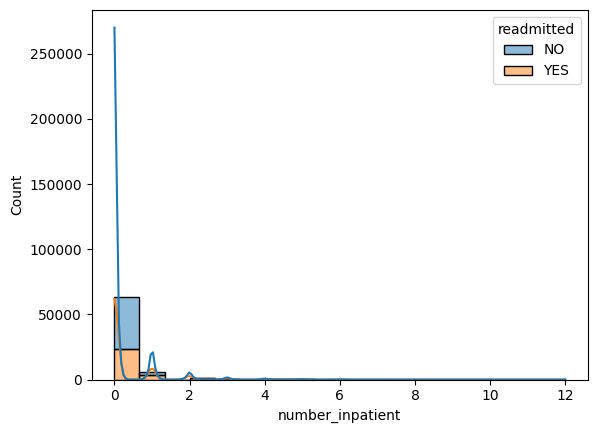

In [ ]:
describeColumnNumerical(df, 'number_inpatient')

Column name: number_diagnoses
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: number_diagnoses
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean         7.245753
std          1.994651
min          1.000000
25%          6.000000
50%          8.000000
75%          9.000000
max         16.000000
Name: number_diagnoses, dtype: float64



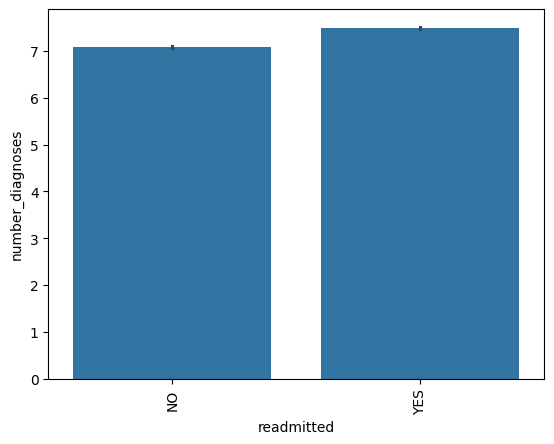

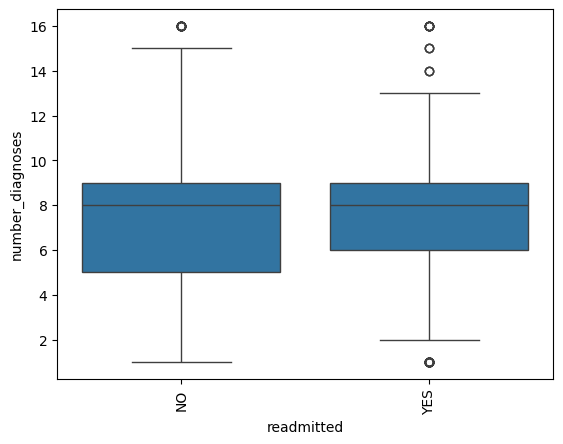

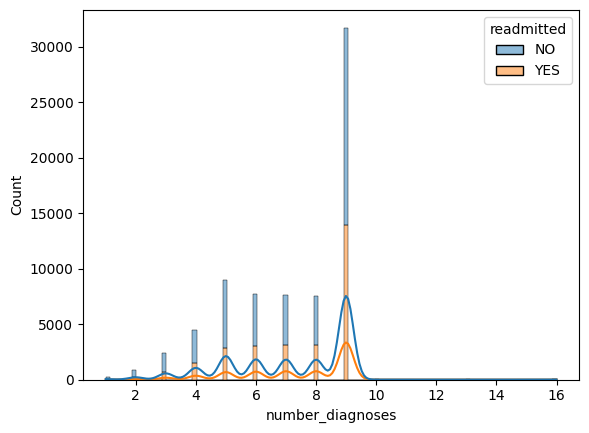

In [ ]:
describeColumnNumerical(df, 'number_diagnoses')

## 'num_lab_procedures'

Column name: num_lab_procedures
Data type: int64

Count of NAs: 0, %NAs = 0.0

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: num_lab_procedures
Non-Null Count  Dtype
--------------  -----
71515 non-null  int64
dtypes: int64(1)
memory usage: 1.1 MB
None

count    71515.000000
mean        43.075858
std         19.952151
min          1.000000
25%         31.000000
50%         44.000000
75%         57.000000
max        132.000000
Name: num_lab_procedures, dtype: float64



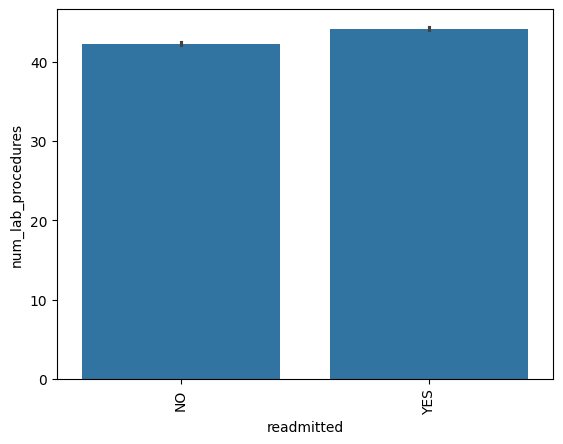

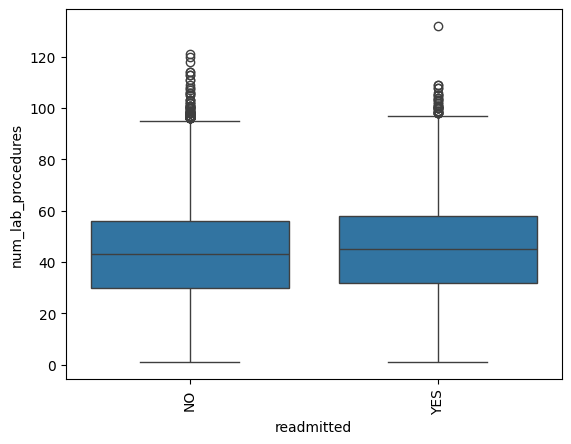

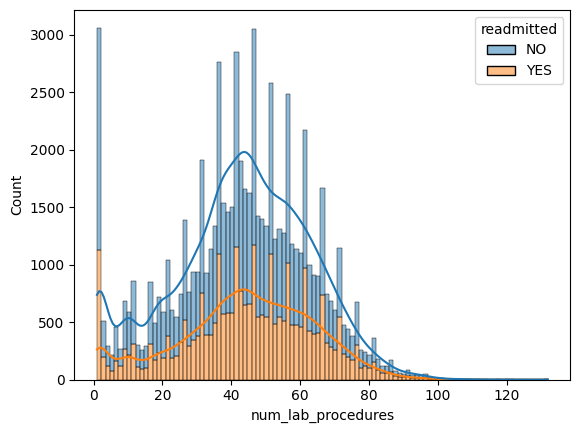

In [ ]:
describeColumnNumerical(df, 'num_lab_procedures')

# Bivariate Analysis

## Few common helpers

In [ ]:
def pairedAnalysis(df, column1, column2):
  print('Contigency Table')
  df_ct = pd.crosstab(df[column2], df[column1])
  print(df_ct)

  print()
  print('Contigency Table - Normalized')
  df_pct = df_ct.div(df_ct.sum(axis=1), axis=0)
  print(df_pct)

  print()
  df_pct.plot(kind='bar', stacked=True)
  plt.show()

  print()
  sns.heatmap(df_pct, annot=True, fmt='g')
  plt.show()

  print()
  print("chi2-statistics: ")
  chi2_stats = chi2_contingency(pd.crosstab(df[column2], df[column1]))
  print(f'statistic: {chi2_stats.statistic}')
  print(f'p-value: {chi2_stats.pvalue}')

  print()
  print('Count plot')
  sns.countplot(x=column2, hue = column1, data=df)
  plt.show()

  print()
  print('ClusterMap')
  sns.clustermap(df_ct)
  plt.show()


In [ ]:
def cramers_v(x, y):
    """
    Calculates Cramér's V statistic for categorical-categorical association.

    Args:
        x: pandas Series (categorical column).
        y: pandas Series (categorical column).

    Returns:
        float: Cramér's V statistic.
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

## 1. 'readmitted' and 'race'

Contigency Table
readmitted          NO    YES
race                         
AfricanAmerican   7924   4963
Asian              349    148
Caucasian        31571  21920
Hispanic           982    535
Other              786    391
Unknown           1370    576

Contigency Table - Normalized
readmitted             NO       YES
race                               
AfricanAmerican  0.614883  0.385117
Asian            0.702213  0.297787
Caucasian        0.590211  0.409789
Hispanic         0.647330  0.352670
Other            0.667799  0.332201
Unknown          0.704008  0.295992



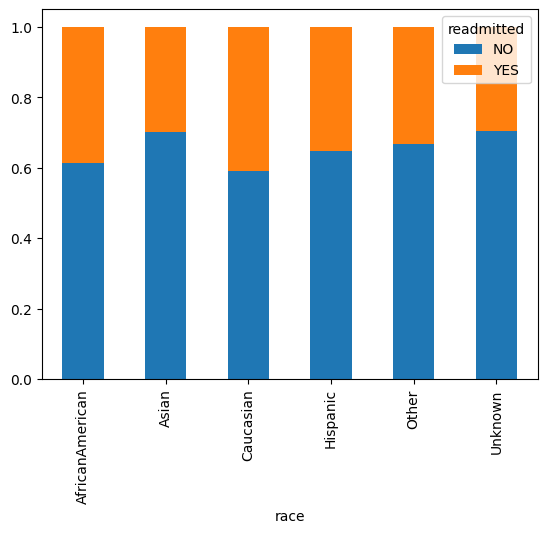

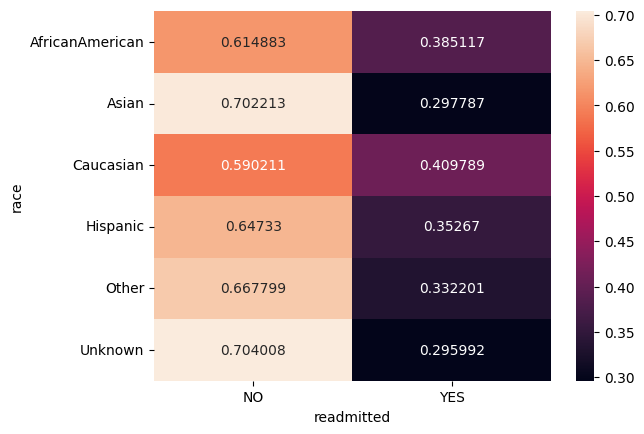


chi2-statistics: 
statistic: 179.14394262565622
p-value: 8.151948686668105e-37

Count plot


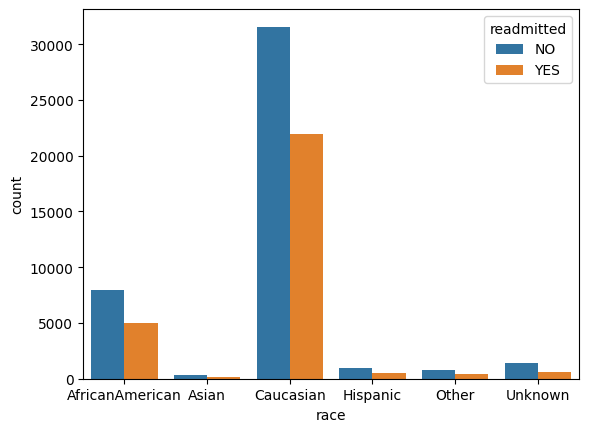


ClusterMap


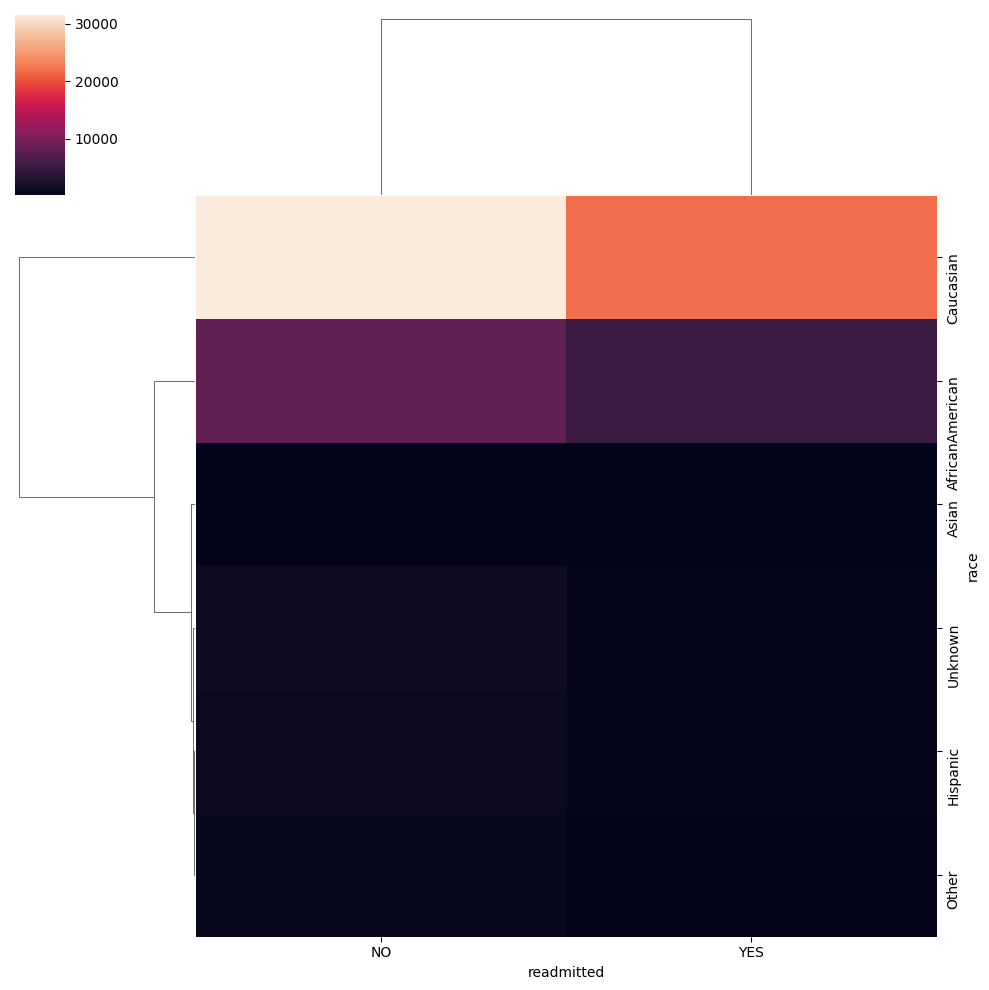

In [ ]:
pairedAnalysis(df, 'readmitted', 'race')

There does not appear to be any correlation between 'race' and 'readmitted' columns

## 'readmitted' and 'insulin'

Contigency Table
readmitted     NO    YES
insulin                 
-1.0         4181   3324
 0.0        21553  13365
 1.0        13296   8833
 2.0         3952   3011

Contigency Table - Normalized
readmitted        NO       YES
insulin                       
-1.0        0.557095  0.442905
 0.0        0.617246  0.382754
 1.0        0.600841  0.399159
 2.0        0.567571  0.432429



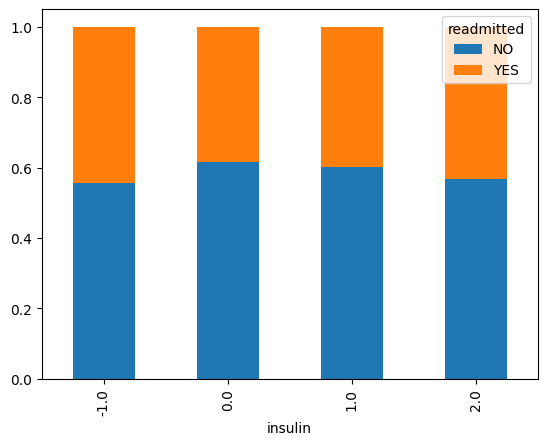

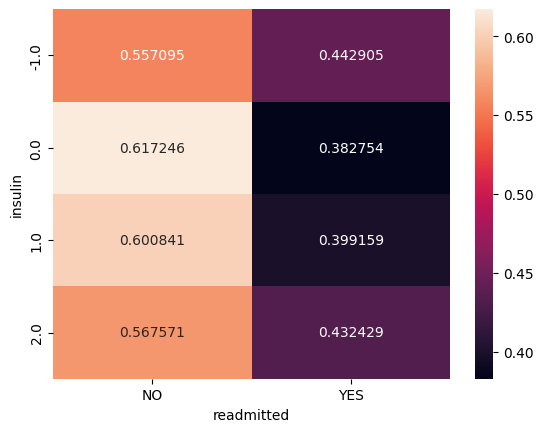


chi2-statistics: 
statistic: 131.21393936835756
p-value: 2.961133098011275e-28

Count plot


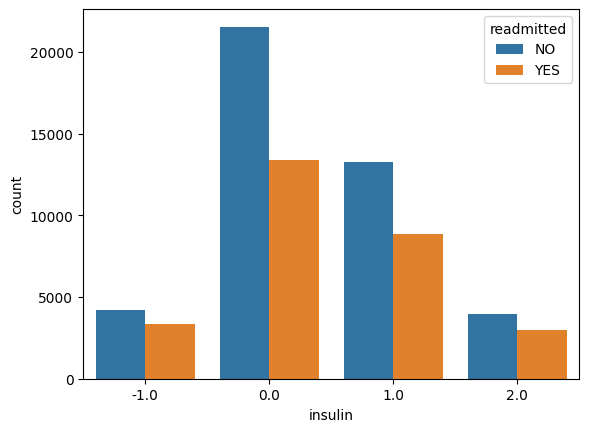


ClusterMap


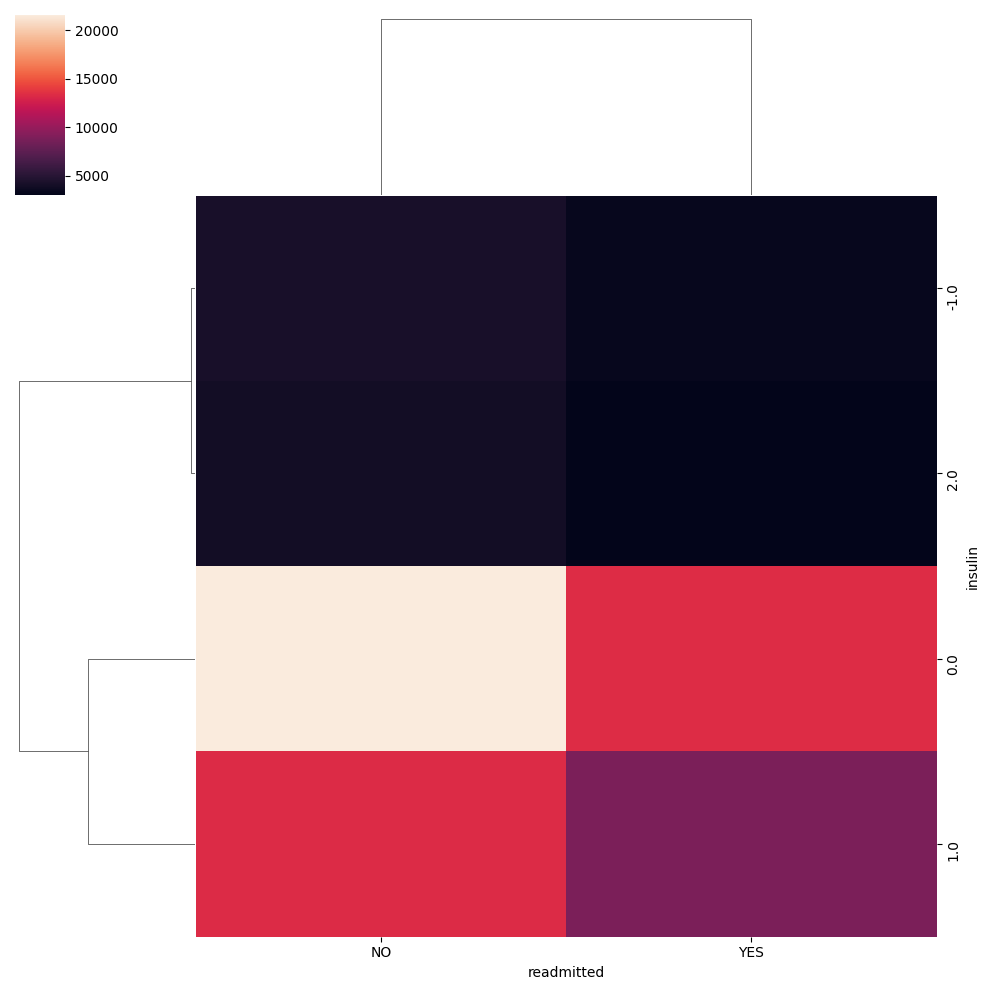

In [ ]:
pairedAnalysis(df, 'readmitted', 'insulin')

In [ ]:
cramers_v(df['readmitted'], df['insulin'])

0.04234206319055997

##'diabetesMed' and 'readmitted'

Contigency Table
readmitted      NO    YES
diabetesMed              
No           11291   5907
Yes          31691  22626

Contigency Table - Normalized
readmitted         NO       YES
diabetesMed                    
No           0.656530  0.343470
Yes          0.583445  0.416555



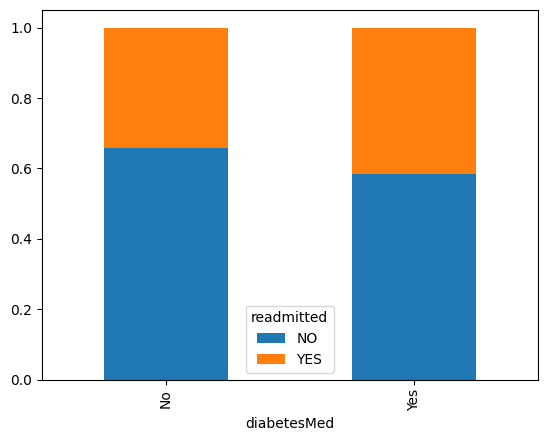

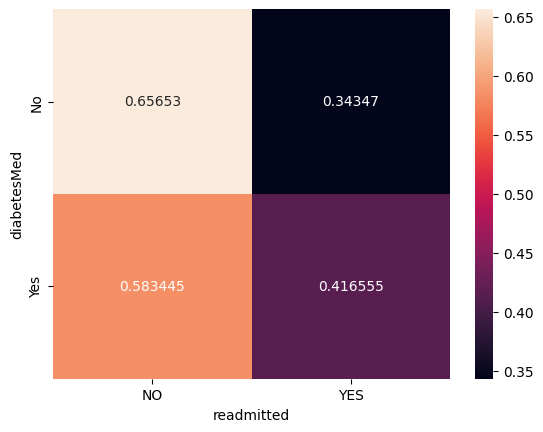


chi2-statistics: 
statistic: 290.6513244944391
p-value: 3.5862382923886674e-65

Count plot


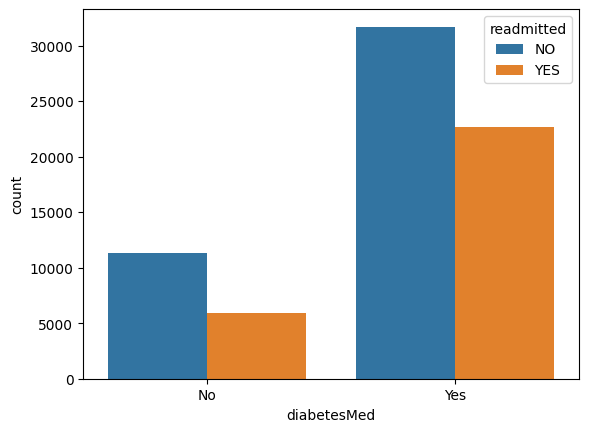


ClusterMap


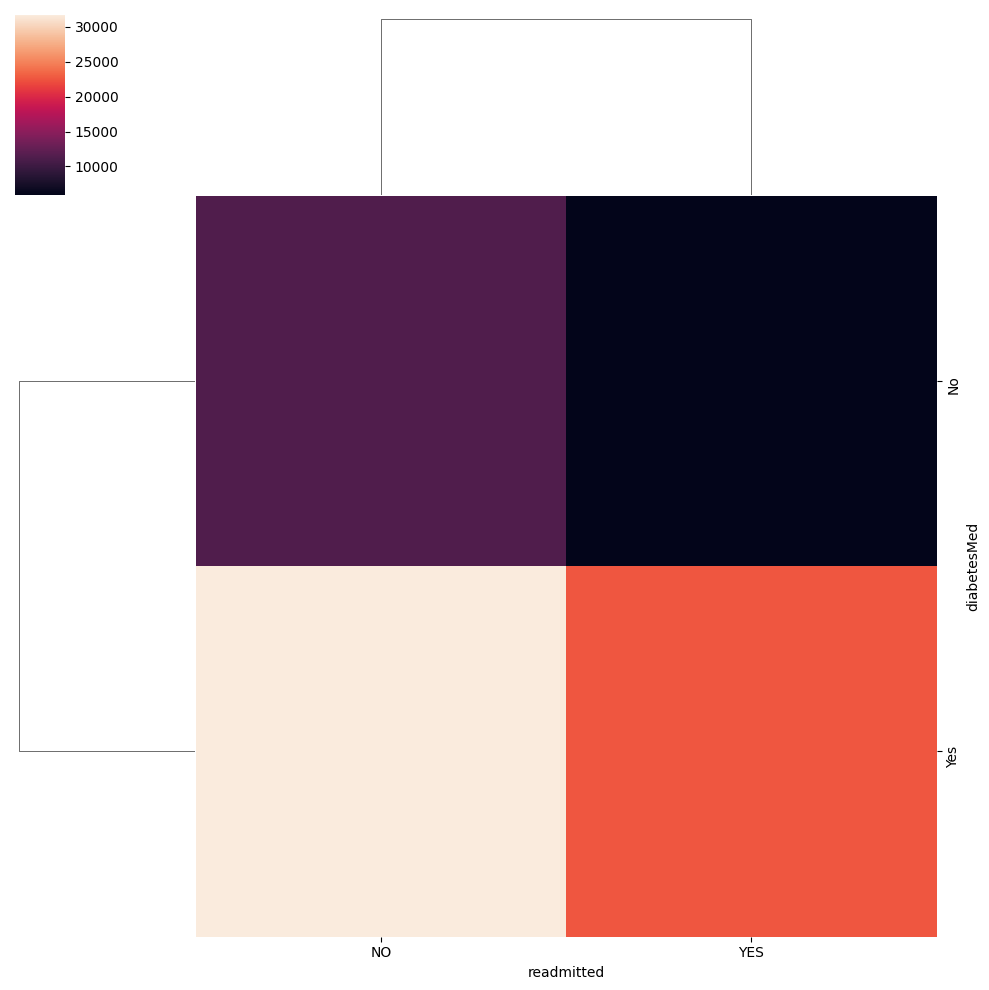

In [ ]:
pairedAnalysis(df, 'readmitted', 'diabetesMed')

## 'readmitted' and 'change'

Contigency Table
readmitted     NO    YES
change                  
Ch          18561  13461
No          24421  15072

Contigency Table - Normalized
readmitted        NO       YES
change                        
Ch          0.579633  0.420367
No          0.618363  0.381637



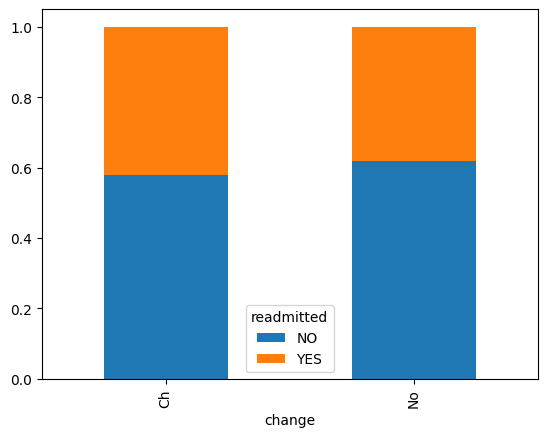

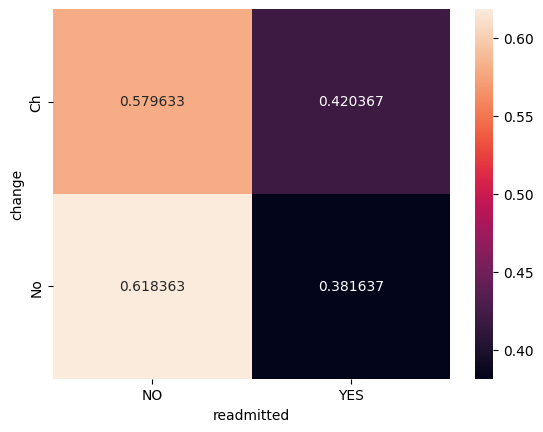


chi2-statistics: 
statistic: 110.45673760652895
p-value: 7.782544033927654e-26

Count plot


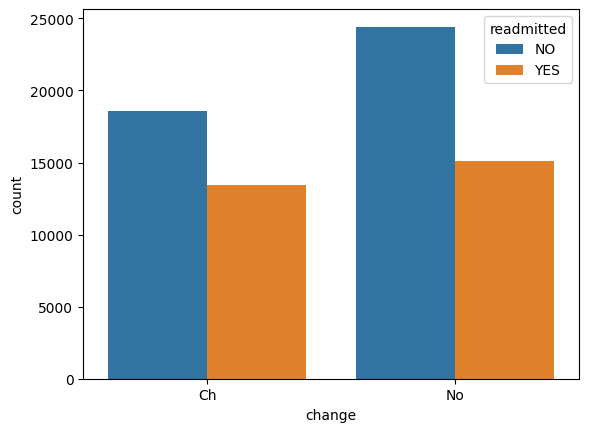


ClusterMap


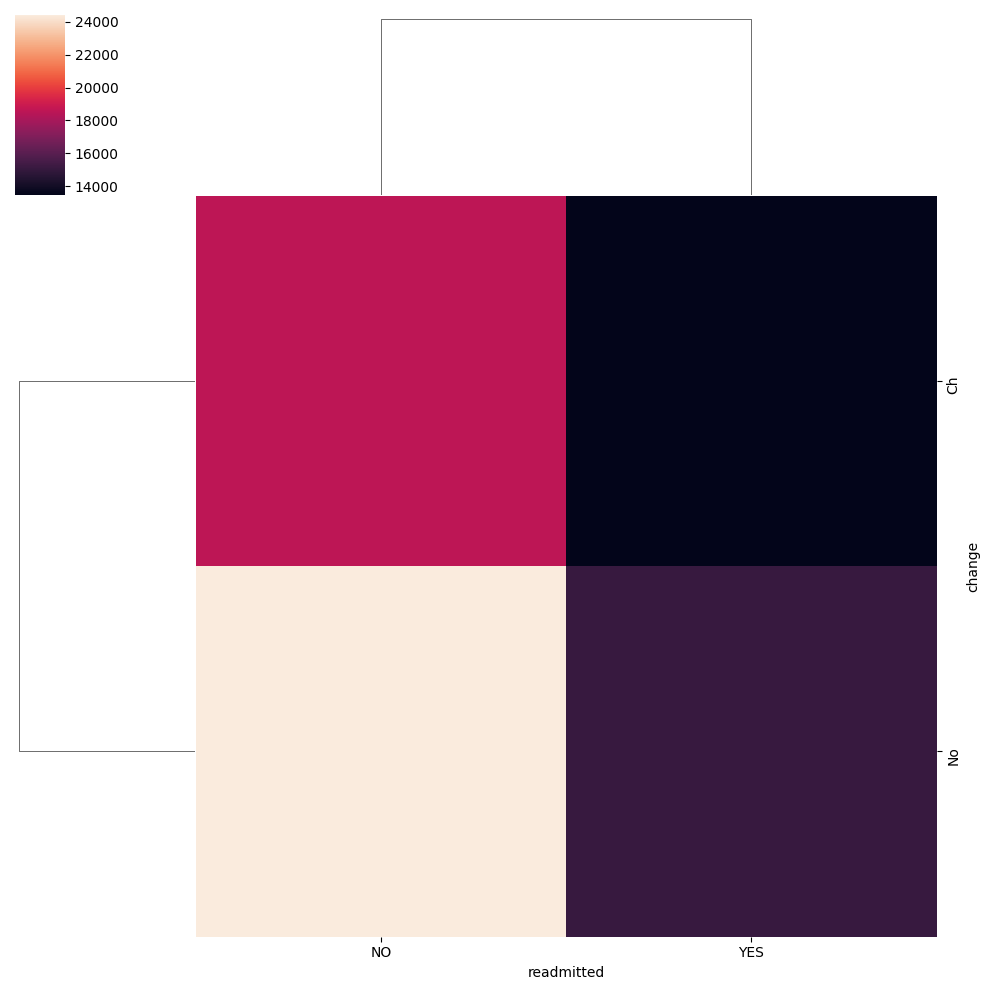

In [ ]:
pairedAnalysis(df, 'readmitted', 'change')

## 'readmitted' and 'medical_speciality'

Contigency Table
readmitted                   NO    YES
medical_specialty                     
AllergyandImmunology          1      5
Anesthesiology                4      3
Anesthesiology-Pediatric      9      4
Cardiology                 2566   1699
Cardiology-Pediatric          2      5
...                         ...    ...
Surgery-Thoracic             60     32
Surgery-Vascular            201    161
SurgicalSpecialty            18      8
Unknown                   20276  14199
Urology                     369    161

[71 rows x 2 columns]

Contigency Table - Normalized
readmitted                      NO       YES
medical_specialty                           
AllergyandImmunology      0.166667  0.833333
Anesthesiology            0.571429  0.428571
Anesthesiology-Pediatric  0.692308  0.307692
Cardiology                0.601641  0.398359
Cardiology-Pediatric      0.285714  0.714286
...                            ...       ...
Surgery-Thoracic          0.652174  0.347826
Surgery-Vascular 

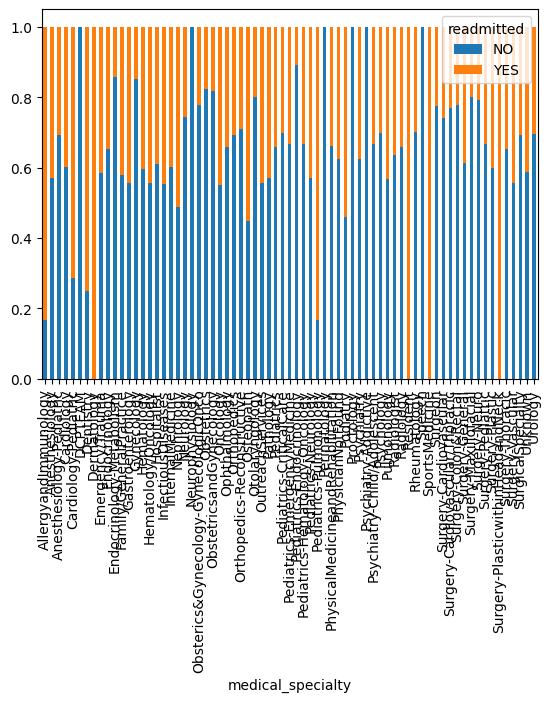

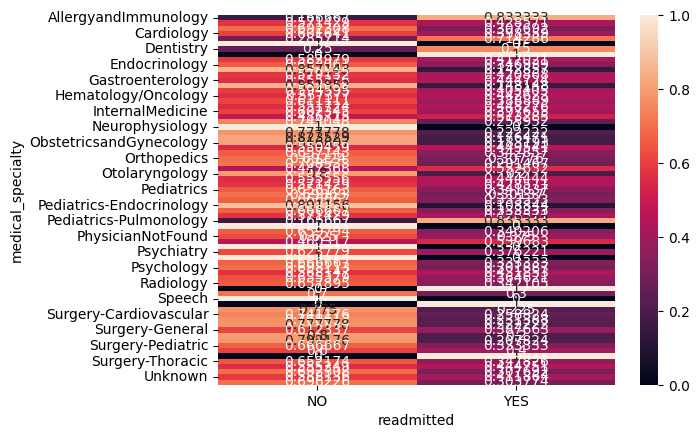


chi2-statistics: 
statistic: 622.8855839598806
p-value: 1.249757206324705e-89

Count plot


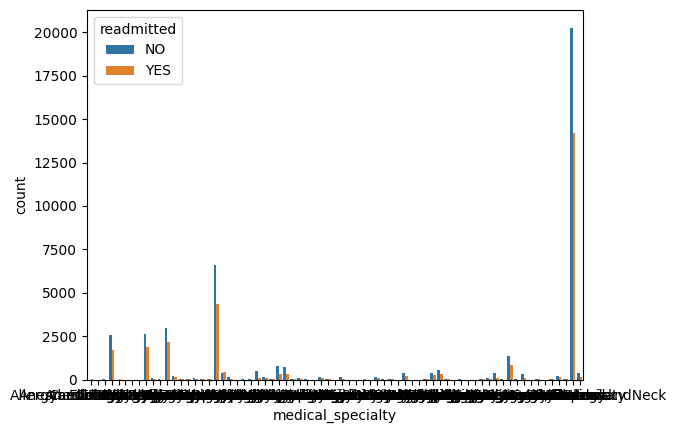


ClusterMap


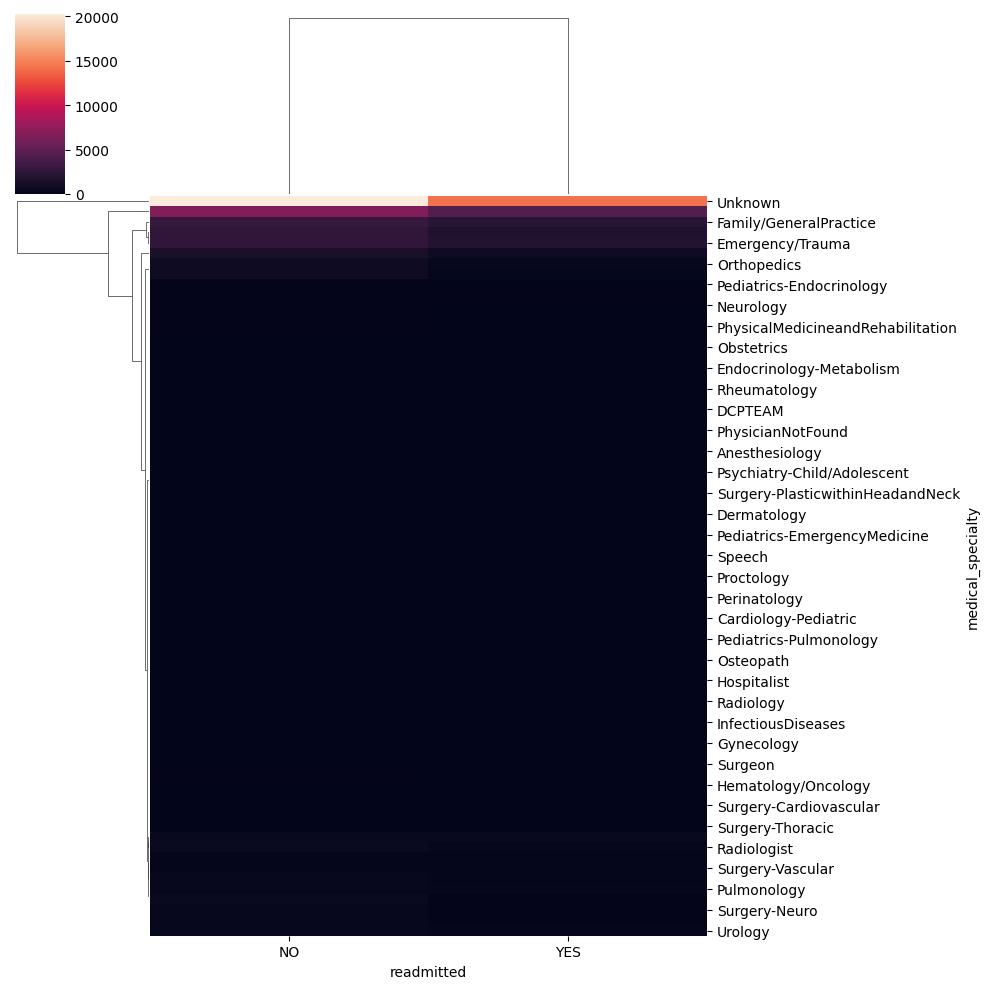

In [ ]:
pairedAnalysis(df, 'readmitted', 'medical_specialty')

## 'readmitted' and 'age-binned'

Contigency Table
readmitted     NO   YES
age-binned             
0-30         1261   555
30-40        1822   877
40-50        4426  2452
50-60        7853  4613
60-70        9593  6366
70-80       10252  7956
80-90        6521  5068
90-100       1254   646

Contigency Table - Normalized
readmitted        NO       YES
age-binned                    
0-30        0.694383  0.305617
30-40       0.675065  0.324935
40-50       0.643501  0.356499
50-60       0.629953  0.370047
60-70       0.601103  0.398897
70-80       0.563049  0.436951
80-90       0.562689  0.437311
90-100      0.660000  0.340000



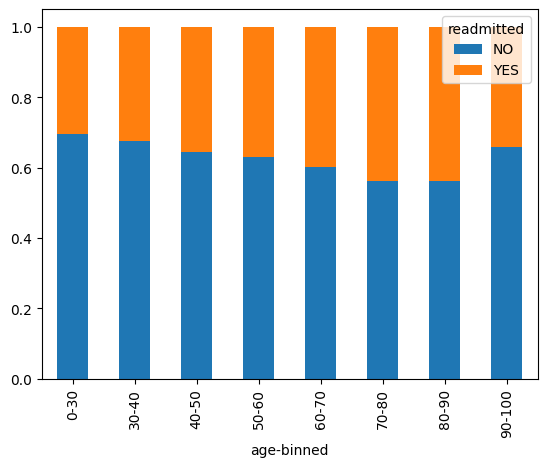

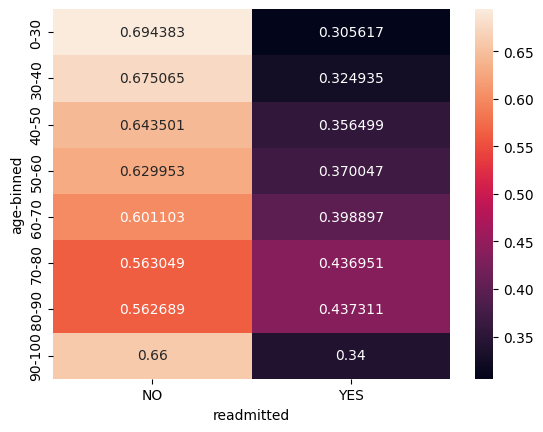


chi2-statistics: 
statistic: 431.0532340705917
p-value: 5.190377329559233e-89

Count plot


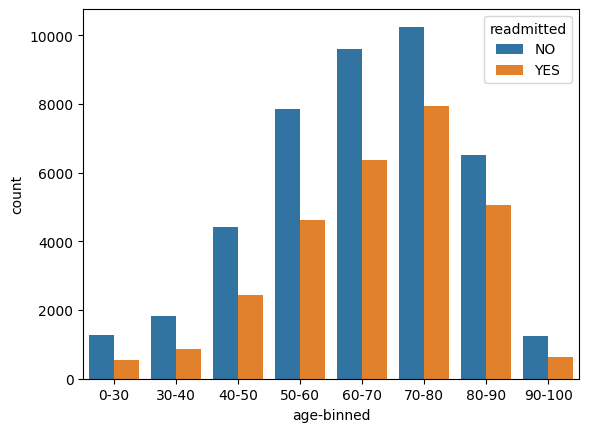


ClusterMap


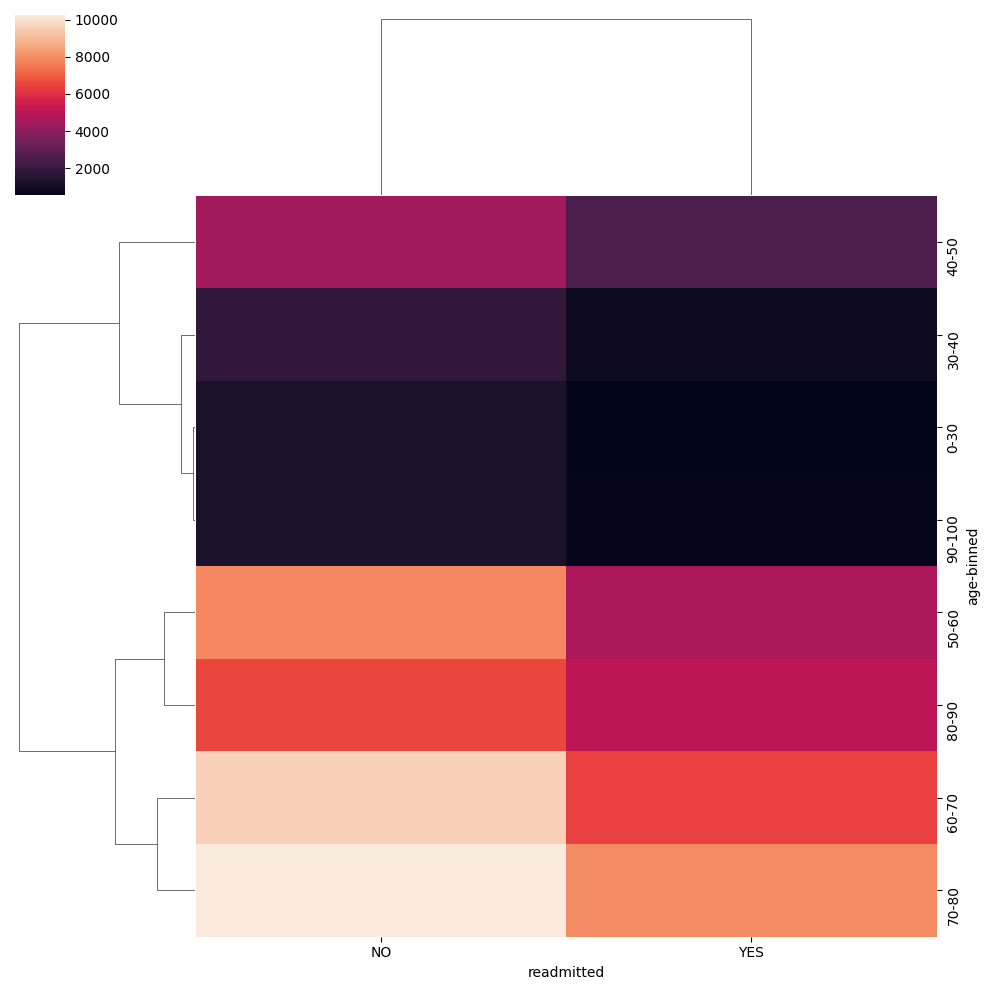

In [ ]:
pairedAnalysis(df, 'readmitted', 'age-binned')

## 'readmitted' and 'max_glu_serum'

Contigency Table
readmitted        NO    YES
max_glu_serum              
0              41030  27029
1               1014    717
2                538    431
3                400    356

Contigency Table - Normalized
readmitted           NO       YES
max_glu_serum                    
0              0.602859  0.397141
1              0.585789  0.414211
2              0.555212  0.444788
3              0.529101  0.470899



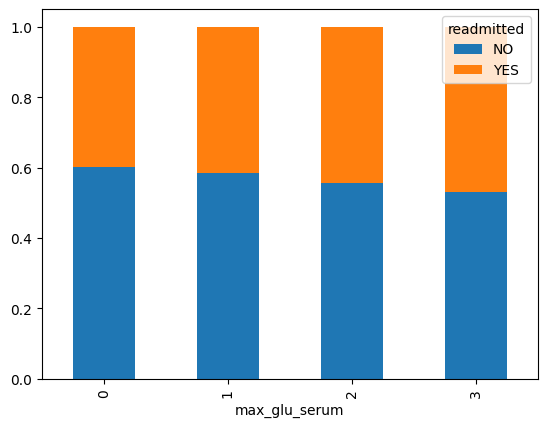

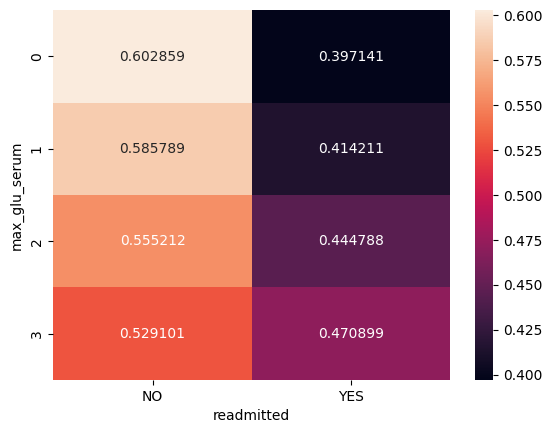


chi2-statistics: 
statistic: 27.421495628535524
p-value: 4.803234329355037e-06

Count plot


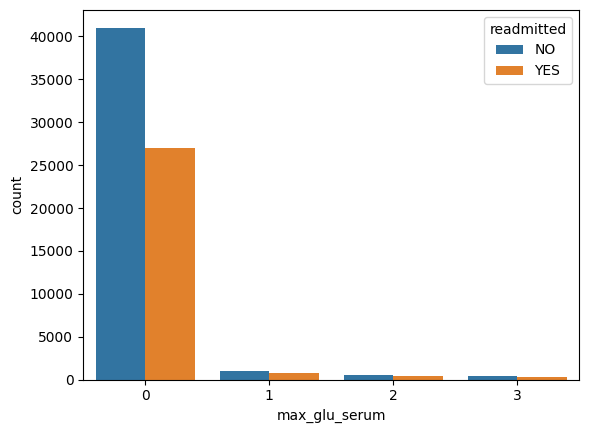


ClusterMap


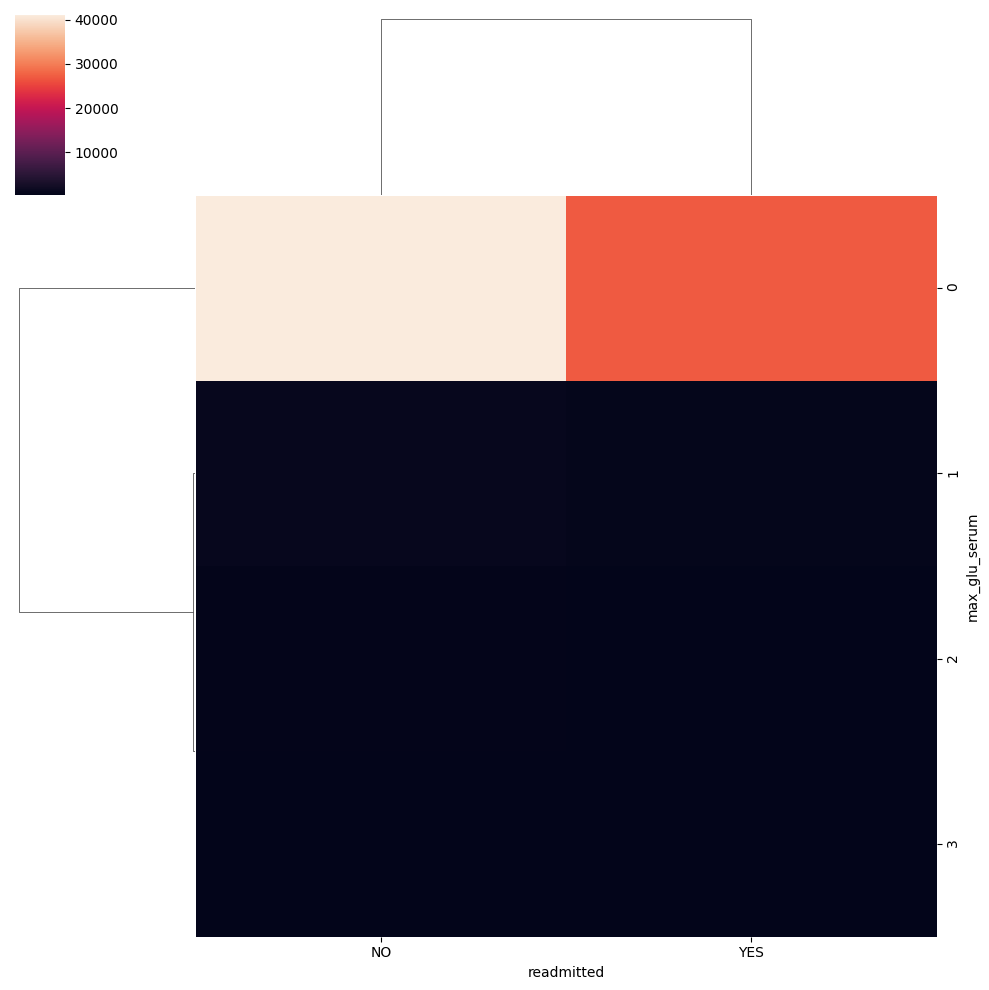

In [ ]:
pairedAnalysis(df, 'readmitted', 'max_glu_serum')

## 'readmitted' and 'A1Cresult'

Contigency Table
readmitted     NO    YES
A1Cresult               
0           34939  23590
1            2426   1365
2            1783   1108
3            3834   2470

Contigency Table - Normalized
readmitted        NO       YES
A1Cresult                     
0           0.596952  0.403048
1           0.639937  0.360063
2           0.616742  0.383258
3           0.608185  0.391815



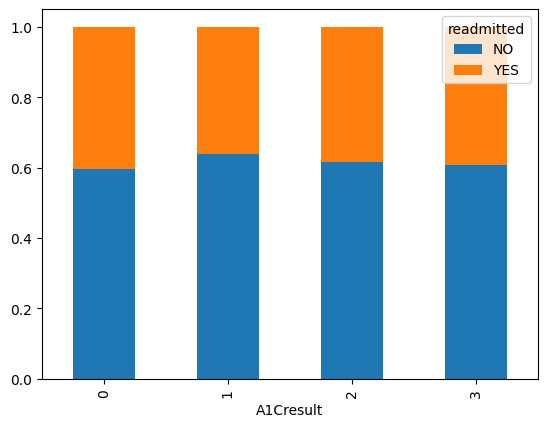

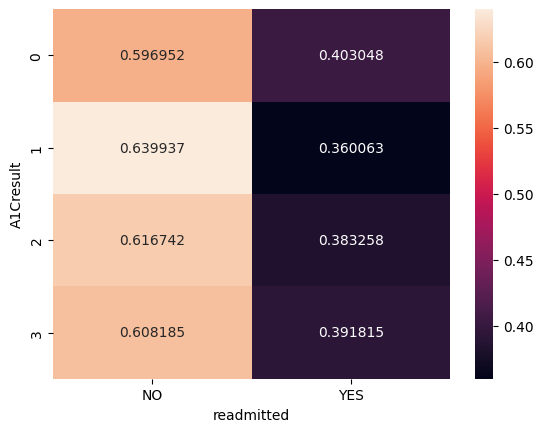


chi2-statistics: 
statistic: 32.31232626318709
p-value: 4.4973577972954047e-07

Count plot


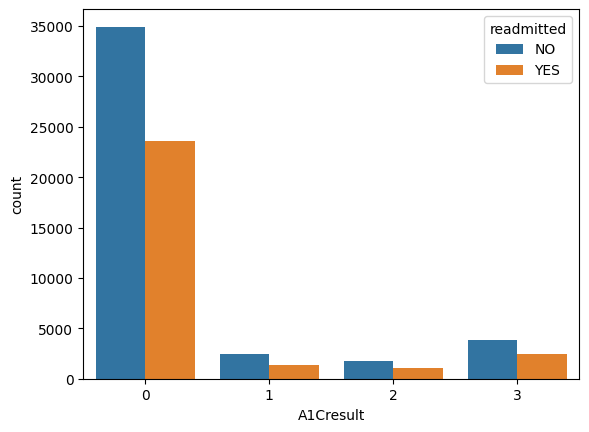


ClusterMap


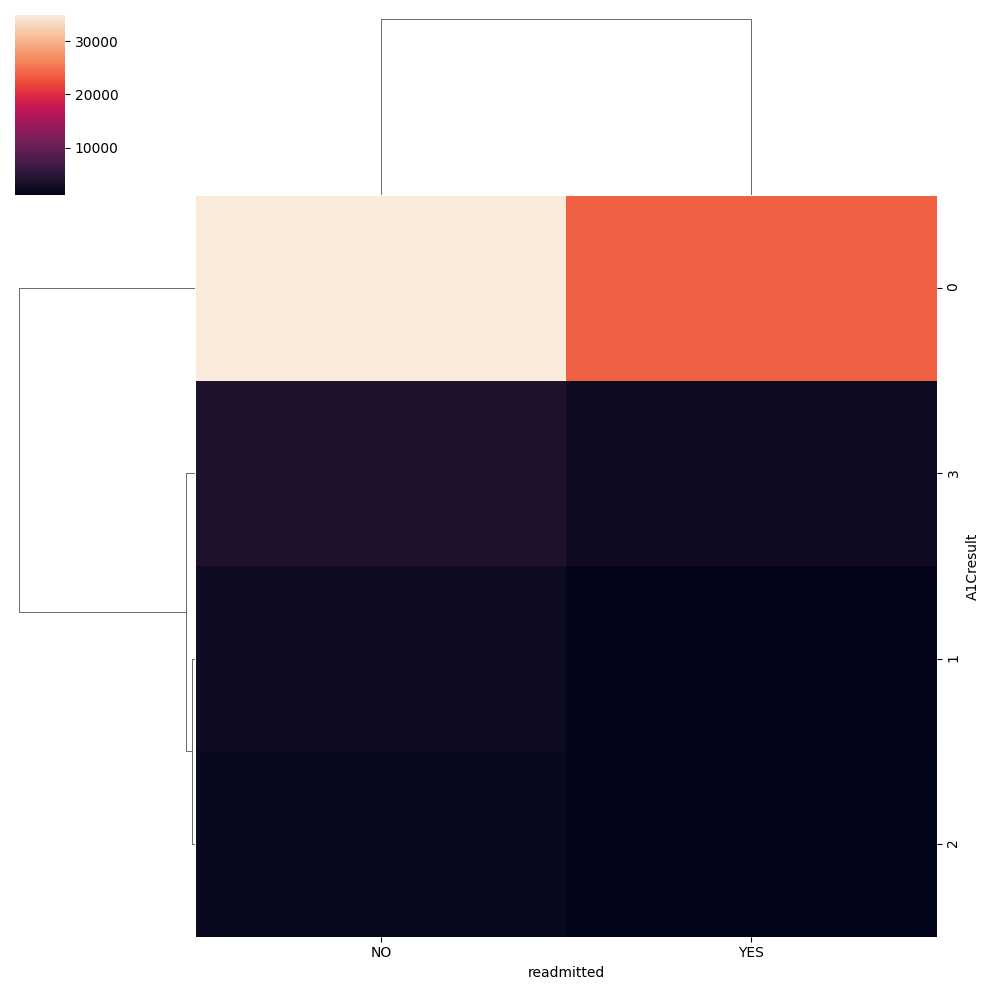

In [ ]:
pairedAnalysis(df, 'readmitted', 'A1Cresult')

2. 'gender' and 'readmitted'

Contigency Table
readmitted     NO    YES
gender                  
Female      22561  15464
Male        20421  13069

Contigency Table - Normalized
readmitted        NO       YES
gender                        
Female      0.593320  0.406680
Male        0.609764  0.390236



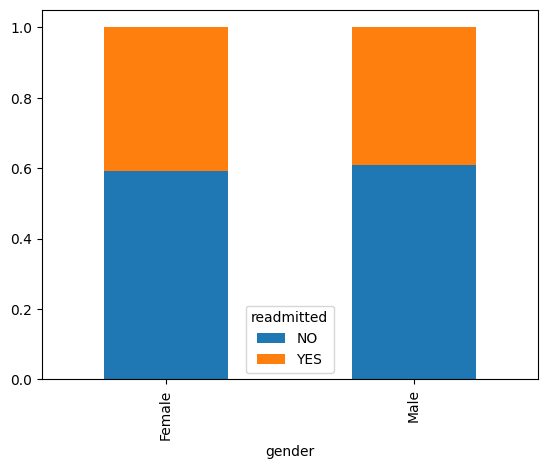

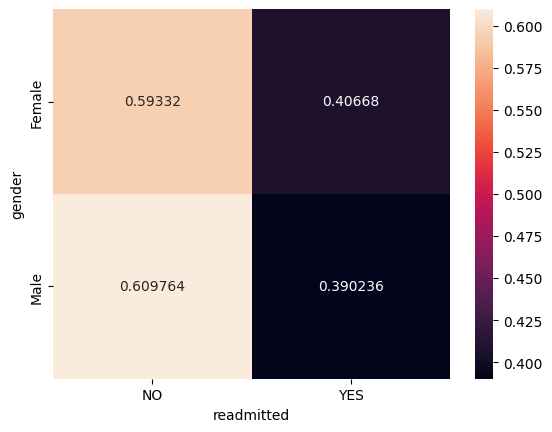


chi2-statistics: 
statistic: 20.01123861068891
p-value: 7.698834571207488e-06

Count plot


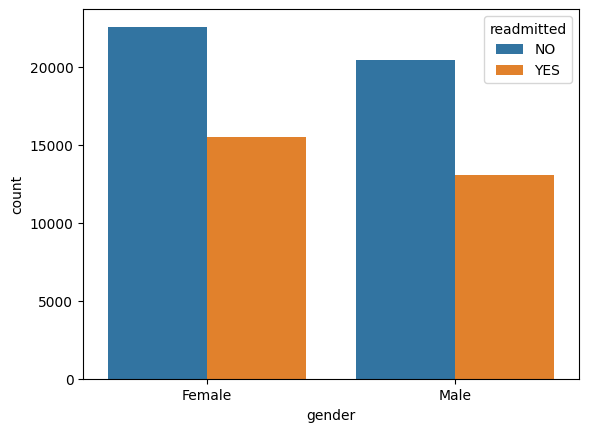


ClusterMap


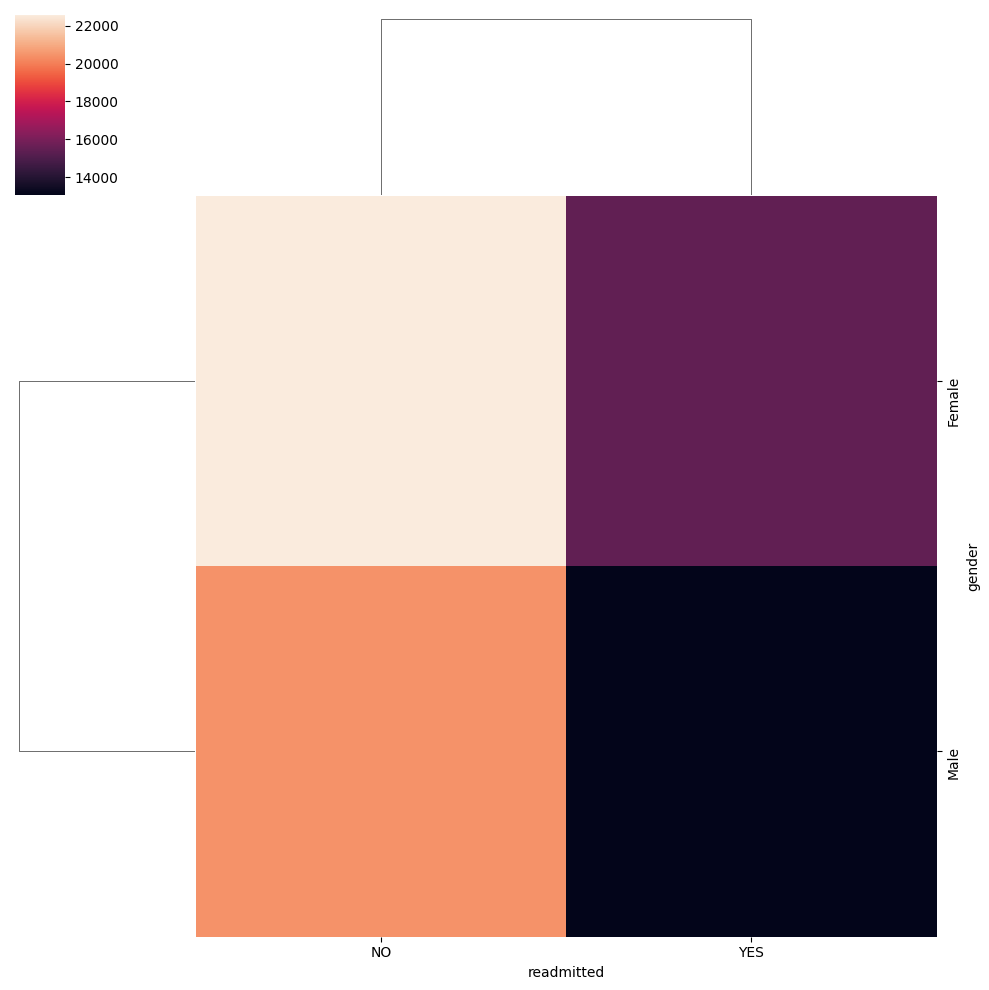

In [ ]:
pairedAnalysis(df, 'readmitted', 'gender')

# Analysis of Numeric Columns

In [ ]:
# Select only numeric columns for correlation calculation
numeric_df = df.select_dtypes(include=['float64', 'int64']).drop(columns = ['encounter_id', 'patient_nbr'])
numeric_df['readmitted'] = df['readmitted'].apply(lambda x : 1 if x == 'YES' else 0)

# Now calculate the correlation with the 'readmitted' column
numeric_df.corr()['readmitted']

admission_type_id           0.020218
discharge_disposition_id   -0.008744
admission_source_id         0.044068
time_in_hospital            0.059054
num_lab_procedures          0.045893
num_procedures             -0.028009
num_medications             0.034149
number_outpatient           0.064015
number_emergency            0.076523
number_inpatient            0.141442
number_diagnoses            0.100568
max_glu_serum               0.019464
A1Cresult                  -0.011585
metformin                  -0.017001
repaglinide                 0.019414
glimepiride                 0.002128
glipizide                   0.023487
glyburide                   0.006846
pioglitazone                0.016181
rosiglitazone               0.022745
insulin                     0.004985
readmitted                  1.000000
Name: readmitted, dtype: float64

## A few help functions

In [ ]:
def pairedAnalysisCategoricalNumerical(df, column1, column2):
  #print('Scatter Plot')
  #plt.scatter(df[column1], df[column2])
  #plt.xlabel(column1)
  #plt.ylabel(column2)
  #plt.show()

  print()
  sns.boxplot(x=column1, y=column2, data=df)
  plt.show()

  print()

## 'readmitted', 'time_in_hospital',

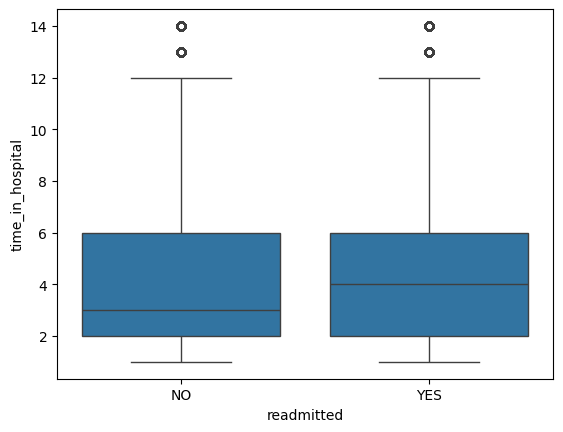

In [ ]:
pairedAnalysisCategoricalNumerical(df, 'readmitted', 'time_in_hospital')

## 'readmitted' and 'number_emergency'

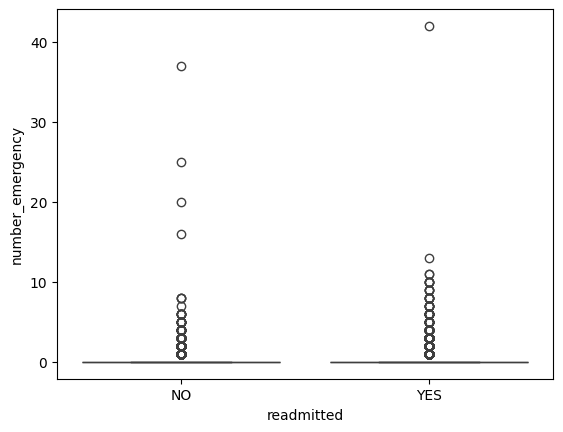

In [ ]:
pairedAnalysisCategoricalNumerical(df, 'readmitted', 'number_emergency')

# Scratchpad

In [ ]:
df['change'].info()

<class 'pandas.core.series.Series'>
Index: 71515 entries, 0 to 101765
Series name: change
Non-Null Count  Dtype   
--------------  -----   
71515 non-null  category
dtypes: category(1)
memory usage: 628.7 KB


In [ ]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'change', 'diabetesMed', 'readmitted', 'age-binned',
       'max_glu_serum_measured', 'A1Cresult_measured', 'repaglinide_measured',
       'glimepiride_measured', 'rosiglitazone_measured',
       'pioglitazone_measured', 'glyburide_measured', 'glipizide_measured',
       'metformin_measured', 'insulin_measured'],
      dtype='object')

In [ ]:
df['admission_type_id'] = df['admission_type_id'].astype('category')
df['admission_source_id'] = df['admission_source_id'].astype('category')
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype('category')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71515 entries, 0 to 101765
Data columns (total 43 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   encounter_id              71515 non-null  int64   
 1   patient_nbr               71515 non-null  int64   
 2   race                      71515 non-null  category
 3   gender                    71515 non-null  category
 4   admission_type_id         71515 non-null  category
 5   discharge_disposition_id  71515 non-null  category
 6   admission_source_id       71515 non-null  category
 7   time_in_hospital          71515 non-null  int64   
 8   medical_specialty         71515 non-null  category
 9   num_lab_procedures        71515 non-null  int64   
 10  num_procedures            71515 non-null  int64   
 11  num_medications           71515 non-null  int64   
 12  number_outpatient         71515 non-null  int64   
 13  number_emergency          71515 non-null  int64   

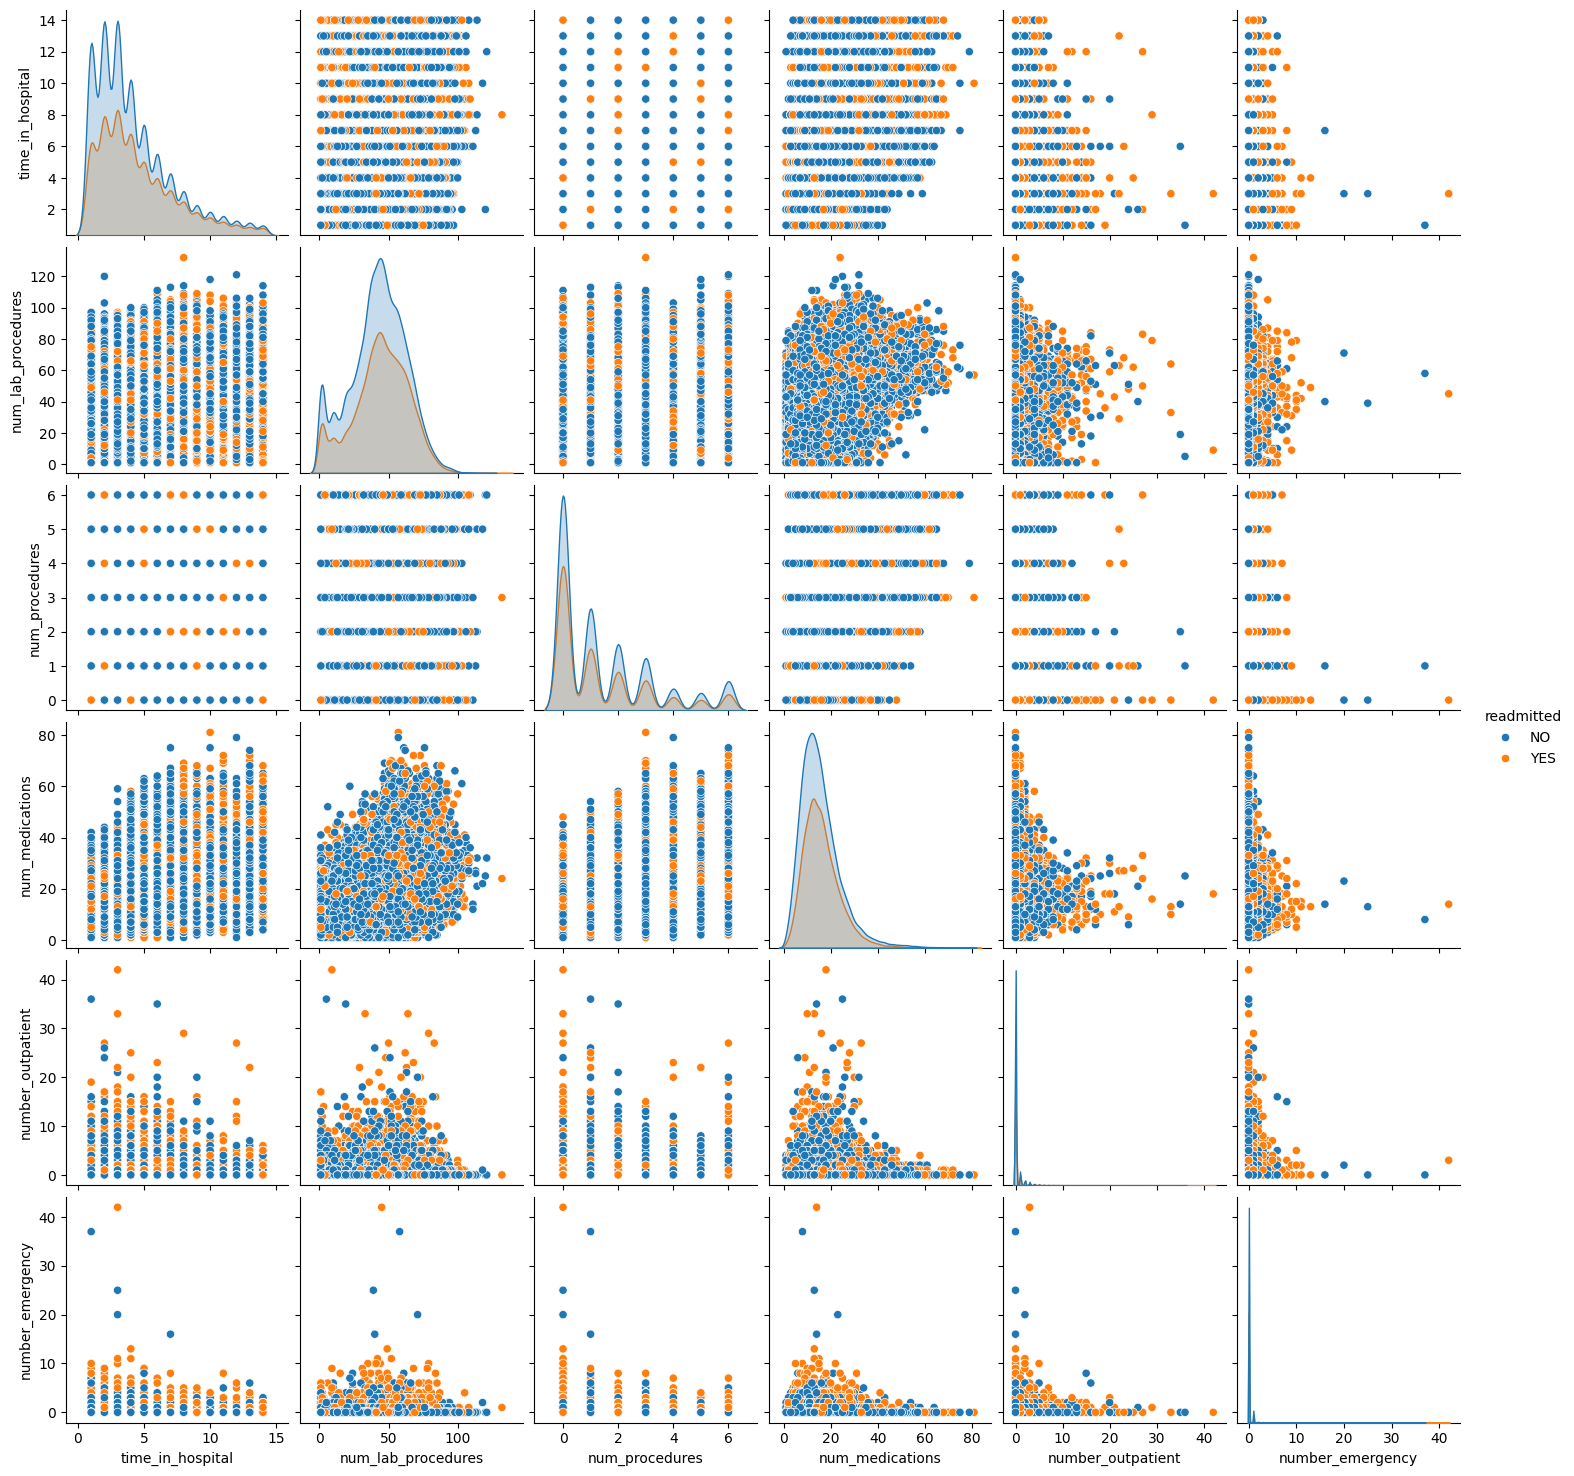

In [ ]:
tempdf = df.drop(columns = ['encounter_id', 'patient_nbr'])
tempdf = df[['time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency', 'readmitted']]
sns.pairplot(tempdf, hue='readmitted')
plt.show()

# Multi-variate analysis

In [ ]:
def analyze(df):
  corr = df.corr()
  sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
  plt.show()

In [ ]:
# Features and target
X = df.drop(columns=['readmitted', 'encounter_id', 'patient_nbr'])
y = df['readmitted']

In [ ]:

numerical_columns = X.select_dtypes(include=['number']).columns
categorical_columns = X.select_dtypes(include=['category']).columns

In [ ]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'medical_specialty', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'glimepiride',
       'glipizide', 'glyburide', 'pioglitazone', 'rosiglitazone', 'insulin',
       'change', 'diabetesMed', 'readmitted', 'age-binned',
       'max_glu_serum_measured', 'A1Cresult_measured', 'repaglinide_measured',
       'glimepiride_measured', 'rosiglitazone_measured',
       'pioglitazone_measured', 'glyburide_measured', 'glipizide_measured',
       'metformin_measured', 'insulin_measured'],
      dtype='object')

# Model Training

In [ ]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing for numerical data: scaling
numerical_transformer = StandardScaler()

# Preprocessing for categorical data: one-hot encoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

In [ ]:
model = LogisticRegression(max_iter=5000, random_state = 42)

rfe = RFE(model, n_features_to_select=10)

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rfe)
])

clf.fit(X_train, y_train)

# Get the feature names after the preprocessing step
feature_names = preprocessor.get_feature_names_out()

# Select the features based on the RFE mask
selected_features = feature_names[rfe.support_]

print("Selected features:", selected_features)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

print(model.coef_, model.intercept_)

X_train_transformed = preprocessor.transform(X_train)


coef_df = pd.DataFrame(model.coef_, columns=feature_names).T
coef_df.columns = [f"Coefficient_Class_{i}" for i in range(coef_df.shape[1])]  # Label columns if you have multiple classes

coef_df.index.name = 'Feature'
coef_df.to_csv("/content/drive/MyDrive/IISc/DSIP/feature_coefficients_2.csv")
print(coef_df)


Selected features: ['cat__discharge_disposition_id_11' 'cat__discharge_disposition_id_13'
 'cat__discharge_disposition_id_14'
 'cat__medical_specialty_Pediatrics-Endocrinology' 'cat__diag_1_218'
 'cat__diag_1_250' 'cat__diag_1_278' 'cat__diag_1_V58' 'cat__diag_2_648'
 'cat__diag_3_536']
Model accuracy: 0.61


AttributeError: 'LogisticRegression' object has no attribute 'coef_'

In [ ]:

# Define the model
model = RandomForestClassifier(random_state=42)

# Create and combine preprocessing and modeling into a pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])


# Define the hyperparameters grid to search
# Access the classifier parameters through 'classifier__' prefix
param_grid = {
    'classifier__n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200],
    'classifier__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

skf = StratifiedKFold(n_splits=5)

# Perform grid search to find the best hyperparameters
grid_search = RandomizedSearchCV(clf, param_grid, cv=skf, verbose=2)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)
# Train the model
best_clf = grid_search.best_estimator_
#clf.fit(X_train, y_train)

# Make predictions
y_pred = best_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy:.2f}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=140; total time=   3.9s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=140; total time=   2.9s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=140; total time=   2.9s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=140; total time=   2.8s
[CV] END classifier__max_depth=6, classifier__min_samples_leaf=2, classifier__min_samples_split=5, classifier__n_estimators=140; total time=   4.1s
[CV] END classifier__max_depth=10, classifier__min_samples_leaf=2, classifier__min_samples_split=10, classifier__n_estimators=40; total time=   2.0s
[CV] END classifier__max_depth=10, classifier__min